## Table of Contents

#### Set-Up
- [Splitting the data](#split)
- [Adjusting some features](#adjusting)
- [Clustering](#clustering)
- [Modeling guidelines](#modeling_guidelines)

#### Testing
- [Logistic Regression](#lr)
- [KNN](#knn)
- [Decision Tree](#dt)
- [Random Forest](#rf)
- [Three-Stage Random Forest](#final)
- [Saving the Best Model](#save)

**Final Modeling Notebook Plan:**  I'm going to test all of my best models from all the previous modeling notebooks on the test set, instead of just my one best model.

Normally you shouldn't test multiple models on the test set, since then there is a danger of tuning your performance to the test set, but I think there are ways to mitigate that problem.

I'm not going to choose the best model based on minor improvements or close comparisons on the test set; I'll value training and validation scores more in terms of performance. But if there is a massive performance change on the test on only some of the models but not others, then statistically that is extremely unlikely to be due to the peculiarities of the test set. Rather, it's a sign of massive overfitting, so using the test set to look for massive changes in performance in different models is a legitimate tactic in my opinion (small differences between the models will not be considered relevant).

Finally, since our best models are random forest models which already have very high accuracy on 7 classes, we aren't going to bother with any of the 4 class models. We will only be testing the best 7 class models of each type.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import re
import json
import pandas_profiling
import requests
import h2o
from subprocess import call
from IPython.display import Image
from graphviz import render
from bs4 import BeautifulSoup
from scipy import stats
from sklearn.decomposition import PCA
from sklearn.preprocessing import scale, StandardScaler, MinMaxScaler
from sklearn.feature_selection import SelectKBest
from sklearn.manifold import TSNE
from sklearn.linear_model import LogisticRegression, Lasso
from sklearn.metrics import precision_recall_fscore_support, log_loss, r2_score, mean_squared_error, f1_score, make_scorer
from sklearn.pipeline import make_pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.cluster import KMeans, DBSCAN, MeanShift
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier, export_graphviz
from scipy.cluster.hierarchy import linkage, dendrogram, fcluster
from h2o.estimators import H2ORandomForestEstimator
from h2o.grid.grid_search import H2OGridSearch

h2o.init()

Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 17.0.1+12-LTS-39, mixed mode, sharing)
  Starting server from C:\Users\Owner\anaconda3\envs\SecondCapstone\Lib\site-packages\h2o\backend\bin\h2o.jar
  Ice root: C:\Users\Owner\AppData\Local\Temp\tmpwksxf8k_
  JVM stdout: C:\Users\Owner\AppData\Local\Temp\tmpwksxf8k_\h2o_Owner_started_from_python.out
  JVM stderr: C:\Users\Owner\AppData\Local\Temp\tmpwksxf8k_\h2o_Owner_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,America/Chicago
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.34.0.3
H2O_cluster_version_age:,2 months and 18 days
H2O_cluster_name:,H2O_from_python_Owner_g4s7lj
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,3.986 Gb
H2O_cluster_total_cores:,8
H2O_cluster_allowed_cores:,8
H2O_cluster_status:,"locked, healthy"


In [2]:
pokemon_abilities_df = pd.read_csv('./data/pokemon_abilities_df.csv', index_col="name")
pokemon_learnsets_df = pd.read_csv('./data/pokemon_learnsets_df.csv', index_col='name')
pokemon_data = pd.read_csv('./data/pokemon_data.csv', index_col="name")

In [3]:
pokemon_data

,hp,atk,def,spa,spd,spe,weight,height,formats,generation,...,Ability Cutoff 2,Ability Cutoff 3,Ability Cutoff 4,Ability Cutoff 5,Ability Cutoff 6,Best Ability,Best Ability <100,Unique Powerful Ability,oldformats,oldformat codes
name,,,,,,,,,,,,,,,,,,,,,
Bulbasaur,45,49,49,65,65,45,6.9,0.7,ZU,RB,...,1.0,0.0,0.0,0.0,0.0,63.636364,63.636364,0,ZU,0
Ivysaur,60,62,63,80,80,60,13.0,1.0,ZU,RB,...,1.0,0.0,0.0,0.0,0.0,63.636364,63.636364,0,ZU,0
Venusaur,80,82,83,100,100,80,100.0,2.0,OU,RB,...,1.0,0.0,0.0,0.0,0.0,63.636364,63.636364,0,UU,4
Charmander,39,52,43,60,50,65,8.5,0.6,ZU,RB,...,1.0,0.0,0.0,0.0,0.0,50.000000,50.000000,0,ZU,0
Charmeleon,58,64,58,80,65,80,19.0,1.1,ZU,RB,...,1.0,0.0,0.0,0.0,0.0,50.000000,50.000000,0,ZU,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Glastrier,100,145,130,65,110,30,800.0,2.2,NU,SS,...,1.0,1.0,1.0,0.0,0.0,75.000000,75.000000,0,NU,2
Spectrier,100,65,60,145,80,130,44.5,2.0,Uber,SS,...,0.0,0.0,0.0,0.0,0.0,1.000000,0.000000,1,Uber,6
Calyrex,100,80,80,80,80,80,7.7,1.1,PU,SS,...,0.0,0.0,0.0,0.0,0.0,18.181818,18.181818,0,ZU,0


<a id="split"></a>
### Splitting the Data

In [4]:
pokemon_data.columns

Index(['hp', 'atk', 'def', 'spa', 'spd', 'spe', 'weight', 'height', 'formats',
       'generation', 'format codes', 'Weaknesses', 'Strong Weaknesses',
       'Resists', 'Strong Resists', 'Immune', 'STAB', 'Resistance Index',
       'Entry Hazards', 'Hazard Removal', 'Removal Deterrent', 'Cleric',
       'Pivot', 'Item Removal', 'Setup', 'Priority', 'HP Drain', 'HP Recovery',
       'Weather Set', 'Weather Gimmick', 'Physical Cutoff 1',
       'Physical Cutoff 2', 'Physical Cutoff 3', 'Physical Cutoff 4',
       'Physical Cutoff 5', 'Physical Cutoff 6', 'Physical Coverage 1',
       'Physical Coverage 2', 'Physical Coverage 3', 'Physical Coverage 4',
       'Special Cutoff 1', 'Special Cutoff 2', 'Special Cutoff 3',
       'Special Cutoff 4', 'Special Cutoff 5', 'Special Cutoff 6',
       'Special Cutoff 7', 'Special Coverage 1', 'Special Coverage 2',
       'Special Coverage 3', 'Special Coverage 4', 'Special Coverage 5',
       'Special Coverage 6', 'Special Coverage 7', 'Special Cove

In [5]:
X = pokemon_data.drop(columns=['weight', 'height', 'Weaknesses', 'Strong Weaknesses', 'Resists',
                                'Strong Resists', 'Immune', 'STAB', 'Physical Cutoff 1', 'Physical Cutoff 2',
                                'Physical Cutoff 4', 'Physical Cutoff 5', 'Physical Cutoff 6',
                                'Physical Coverage 1', 'Physical Coverage 2', 'Physical Coverage 4',
                                'Special Cutoff 1', 'Special Cutoff 2', 'Special Cutoff 4',
                                'Special Cutoff 5', 'Special Cutoff 6', 'Special Cutoff 7',
                                'Special Coverage 1', 'Special Coverage 2', 'Special Coverage 3',
                                'Special Coverage 4', 'Special Coverage 6', 'Special Coverage 7',
                                'Special Coverage 8', 'Special Coverage 9', 'Special Coverage 10',
                                'Ability Cutoff 1', 'Ability Cutoff 2', 'Ability Cutoff 4', 'Ability Cutoff 5',
                                'Ability Cutoff 6', 'Best Ability <100', 'formats', 'generation',
                                'format codes', 'oldformats', 'oldformat codes'])

y_df = pd.DataFrame(pokemon_data[['formats', 'format codes']], index=pokemon_data.index, columns=['formats', 'format codes', 'oldformats', 'oldformat codes'])
y_df['formats4'] = y_df['formats'].replace({'ZU':'Not c', 'PU': 'Low c', 'NU': 'Mid c', 'RU': 'Mid c', 'UU': 'Mid c', 'OU': 'High c', 'Uber': 'High c'})
y_df['format codes4'] = y_df['format codes'].replace({3:2, 4: 2, 5:3, 6:3})
y_df['formats4alt'] = y_df['formats'].replace({'ZU':'Not c', 'PU': 'Low c', 'NU': 'Mid c', 'RU': 'Mid c', 'UU': 'Mid c', 'OU': 'Mid c', 'Uber': 'High c'})
y_df['format codes4alt'] = y_df['format codes'].replace({3:2, 4: 2, 5:2, 6:3})
y_df['formats2'] = y_df['formats'].replace({'ZU':'No', 'PU': 'Yes', 'NU': 'Yes', 'RU': 'Yes', 'UU': 'Yes', 'OU': 'Yes', 'Uber': 'Yes'})
y_df

,formats,format codes,oldformats,oldformat codes,formats4,format codes4,formats4alt,format codes4alt,formats2
name,,,,,,,,,
Bulbasaur,ZU,0,NaN,NaN,Not c,0,Not c,0,No
Ivysaur,ZU,0,NaN,NaN,Not c,0,Not c,0,No
Venusaur,OU,5,NaN,NaN,High c,3,Mid c,2,Yes
Charmander,ZU,0,NaN,NaN,Not c,0,Not c,0,No
Charmeleon,ZU,0,NaN,NaN,Not c,0,Not c,0,No
...,...,...,...,...,...,...,...,...,...
Glastrier,NU,2,NaN,NaN,Mid c,2,Mid c,2,Yes
Spectrier,Uber,6,NaN,NaN,High c,3,High c,3,Yes
Calyrex,PU,1,NaN,NaN,Low c,1,Low c,1,Yes


<a id="adjusting"></a>
### Adjusting some features

- remove: ability cutoff, unique powerful ability

In [6]:
X.columns

Index(['hp', 'atk', 'def', 'spa', 'spd', 'spe', 'Resistance Index',
       'Entry Hazards', 'Hazard Removal', 'Removal Deterrent', 'Cleric',
       'Pivot', 'Item Removal', 'Setup', 'Priority', 'HP Drain', 'HP Recovery',
       'Weather Set', 'Weather Gimmick', 'Physical Cutoff 3',
       'Physical Coverage 3', 'Special Cutoff 3', 'Special Coverage 5',
       'Misc Status', 'Unique Powerful Move', 'Ability Cutoff 3',
       'Best Ability', 'Unique Powerful Ability'],
      dtype='object')

In [7]:
X.drop(columns=['Ability Cutoff 3', 'Unique Powerful Ability'], inplace=True)
X

,hp,atk,def,spa,spd,spe,Resistance Index,Entry Hazards,Hazard Removal,Removal Deterrent,...,HP Recovery,Weather Set,Weather Gimmick,Physical Cutoff 3,Physical Coverage 3,Special Cutoff 3,Special Coverage 5,Misc Status,Unique Powerful Move,Best Ability
name,,,,,,,,,,,,,,,,,,,,,
Bulbasaur,45,49,49,65,65,45,2,0,0,0,...,1,0,5,4,3,5,2,4,0,63.636364
Ivysaur,60,62,63,80,80,60,2,0,0,0,...,1,0,5,4,3,5,2,4,0,63.636364
Venusaur,80,82,83,100,100,80,2,0,0,0,...,1,0,5,6,4,6,4,4,0,63.636364
Charmander,39,52,43,60,50,65,3,0,0,0,...,0,0,3,10,9,6,2,3,0,50.000000
Charmeleon,58,64,58,80,65,80,3,0,0,0,...,0,0,3,10,9,6,2,3,0,50.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Glastrier,100,145,130,65,110,30,-3,0,0,0,...,0,0,1,12,7,3,2,2,0,75.000000
Spectrier,100,65,60,145,80,130,8,0,0,1,...,0,0,0,4,4,4,3,3,0,1.000000
Calyrex,100,80,80,80,80,80,-2,0,0,0,...,0,0,2,3,3,9,4,3,0,18.181818


In [8]:
X.columns

Index(['hp', 'atk', 'def', 'spa', 'spd', 'spe', 'Resistance Index',
       'Entry Hazards', 'Hazard Removal', 'Removal Deterrent', 'Cleric',
       'Pivot', 'Item Removal', 'Setup', 'Priority', 'HP Drain', 'HP Recovery',
       'Weather Set', 'Weather Gimmick', 'Physical Cutoff 3',
       'Physical Coverage 3', 'Special Cutoff 3', 'Special Coverage 5',
       'Misc Status', 'Unique Powerful Move', 'Best Ability'],
      dtype='object')

- fold weather set into weather gimmick

In [9]:
X['Weather Gimmick'].value_counts()

2    289
1    171
0    161
5     70
3     40
4      7
Name: Weather Gimmick, dtype: int64

In [10]:
X['Weather Set'].value_counts()

0    709
1     29
Name: Weather Set, dtype: int64

In [11]:
X.loc[X['Weather Set'] == 1, 'Weather Gimmick'] = 6
X['Weather Gimmick'].value_counts()

2    265
1    167
0    161
5     70
3     39
6     29
4      7
Name: Weather Gimmick, dtype: int64

In [12]:
X.drop(columns=['Weather Set'], inplace=True)
X

,hp,atk,def,spa,spd,spe,Resistance Index,Entry Hazards,Hazard Removal,Removal Deterrent,...,HP Drain,HP Recovery,Weather Gimmick,Physical Cutoff 3,Physical Coverage 3,Special Cutoff 3,Special Coverage 5,Misc Status,Unique Powerful Move,Best Ability
name,,,,,,,,,,,,,,,,,,,,,
Bulbasaur,45,49,49,65,65,45,2,0,0,0,...,2,1,5,4,3,5,2,4,0,63.636364
Ivysaur,60,62,63,80,80,60,2,0,0,0,...,2,1,5,4,3,5,2,4,0,63.636364
Venusaur,80,82,83,100,100,80,2,0,0,0,...,2,1,5,6,4,6,4,4,0,63.636364
Charmander,39,52,43,60,50,65,3,0,0,0,...,0,0,3,10,9,6,2,3,0,50.000000
Charmeleon,58,64,58,80,65,80,3,0,0,0,...,0,0,3,10,9,6,2,3,0,50.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Glastrier,100,145,130,65,110,30,-3,0,0,0,...,0,0,1,12,7,3,2,2,0,75.000000
Spectrier,100,65,60,145,80,130,8,0,0,1,...,0,0,0,4,4,4,3,3,0,1.000000
Calyrex,100,80,80,80,80,80,-2,0,0,0,...,2,0,2,3,3,9,4,3,0,18.181818


- fold hp drain and hp recovery together into a recovery feature

In [13]:
X['HP Recovery'].value_counts()

0    517
1    184
2     37
Name: HP Recovery, dtype: int64

In [14]:
X['HP Drain'].value_counts()

0    482
2    202
1     49
3      4
4      1
Name: HP Drain, dtype: int64

In [15]:
X.loc[X['HP Recovery'] == 1, 'HP Drain'] = 3
X.loc[X['HP Recovery'] == 2, 'HP Drain'] = 4
X['HP Drain'].value_counts()

0    382
3    187
2     91
1     41
4     37
Name: HP Drain, dtype: int64

In [16]:
X.drop(columns=['HP Recovery'], inplace=True)
X

,hp,atk,def,spa,spd,spe,Resistance Index,Entry Hazards,Hazard Removal,Removal Deterrent,...,Priority,HP Drain,Weather Gimmick,Physical Cutoff 3,Physical Coverage 3,Special Cutoff 3,Special Coverage 5,Misc Status,Unique Powerful Move,Best Ability
name,,,,,,,,,,,,,,,,,,,,,
Bulbasaur,45,49,49,65,65,45,2,0,0,0,...,0,3,5,4,3,5,2,4,0,63.636364
Ivysaur,60,62,63,80,80,60,2,0,0,0,...,0,3,5,4,3,5,2,4,0,63.636364
Venusaur,80,82,83,100,100,80,2,0,0,0,...,0,3,5,6,4,6,4,4,0,63.636364
Charmander,39,52,43,60,50,65,3,0,0,0,...,1,0,3,10,9,6,2,3,0,50.000000
Charmeleon,58,64,58,80,65,80,3,0,0,0,...,1,0,3,10,9,6,2,3,0,50.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Glastrier,100,145,130,65,110,30,-3,0,0,0,...,0,0,1,12,7,3,2,2,0,75.000000
Spectrier,100,65,60,145,80,130,8,0,0,1,...,0,0,0,4,4,4,3,3,0,1.000000
Calyrex,100,80,80,80,80,80,-2,0,0,0,...,0,2,2,3,3,9,4,3,0,18.181818


In [17]:
X['HP Recovery'] = X['HP Drain']
X

,hp,atk,def,spa,spd,spe,Resistance Index,Entry Hazards,Hazard Removal,Removal Deterrent,...,HP Drain,Weather Gimmick,Physical Cutoff 3,Physical Coverage 3,Special Cutoff 3,Special Coverage 5,Misc Status,Unique Powerful Move,Best Ability,HP Recovery
name,,,,,,,,,,,,,,,,,,,,,
Bulbasaur,45,49,49,65,65,45,2,0,0,0,...,3,5,4,3,5,2,4,0,63.636364,3
Ivysaur,60,62,63,80,80,60,2,0,0,0,...,3,5,4,3,5,2,4,0,63.636364,3
Venusaur,80,82,83,100,100,80,2,0,0,0,...,3,5,6,4,6,4,4,0,63.636364,3
Charmander,39,52,43,60,50,65,3,0,0,0,...,0,3,10,9,6,2,3,0,50.000000,0
Charmeleon,58,64,58,80,65,80,3,0,0,0,...,0,3,10,9,6,2,3,0,50.000000,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Glastrier,100,145,130,65,110,30,-3,0,0,0,...,0,1,12,7,3,2,2,0,75.000000,0
Spectrier,100,65,60,145,80,130,8,0,0,1,...,0,0,4,4,4,3,3,0,1.000000,0
Calyrex,100,80,80,80,80,80,-2,0,0,0,...,2,2,3,3,9,4,3,0,18.181818,2


In [18]:
X.drop(columns=['HP Drain'], inplace=True)
X

,hp,atk,def,spa,spd,spe,Resistance Index,Entry Hazards,Hazard Removal,Removal Deterrent,...,Priority,Weather Gimmick,Physical Cutoff 3,Physical Coverage 3,Special Cutoff 3,Special Coverage 5,Misc Status,Unique Powerful Move,Best Ability,HP Recovery
name,,,,,,,,,,,,,,,,,,,,,
Bulbasaur,45,49,49,65,65,45,2,0,0,0,...,0,5,4,3,5,2,4,0,63.636364,3
Ivysaur,60,62,63,80,80,60,2,0,0,0,...,0,5,4,3,5,2,4,0,63.636364,3
Venusaur,80,82,83,100,100,80,2,0,0,0,...,0,5,6,4,6,4,4,0,63.636364,3
Charmander,39,52,43,60,50,65,3,0,0,0,...,1,3,10,9,6,2,3,0,50.000000,0
Charmeleon,58,64,58,80,65,80,3,0,0,0,...,1,3,10,9,6,2,3,0,50.000000,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Glastrier,100,145,130,65,110,30,-3,0,0,0,...,0,1,12,7,3,2,2,0,75.000000,0
Spectrier,100,65,60,145,80,130,8,0,0,1,...,0,0,4,4,4,3,3,0,1.000000,0
Calyrex,100,80,80,80,80,80,-2,0,0,0,...,0,2,3,3,9,4,3,0,18.181818,2


In [19]:
X['HP Recovery'].value_counts()

0    382
3    187
2     91
1     41
4     37
Name: HP Recovery, dtype: int64

- considering: removal deterrent (could arguably just remove since its abilities), hazard removal, cleric, entry hazards (all 3 of those might go into misc status)

In [20]:
X.drop(columns=['Removal Deterrent'], inplace=True)
X

,hp,atk,def,spa,spd,spe,Resistance Index,Entry Hazards,Hazard Removal,Cleric,...,Priority,Weather Gimmick,Physical Cutoff 3,Physical Coverage 3,Special Cutoff 3,Special Coverage 5,Misc Status,Unique Powerful Move,Best Ability,HP Recovery
name,,,,,,,,,,,,,,,,,,,,,
Bulbasaur,45,49,49,65,65,45,2,0,0,0,...,0,5,4,3,5,2,4,0,63.636364,3
Ivysaur,60,62,63,80,80,60,2,0,0,0,...,0,5,4,3,5,2,4,0,63.636364,3
Venusaur,80,82,83,100,100,80,2,0,0,0,...,0,5,6,4,6,4,4,0,63.636364,3
Charmander,39,52,43,60,50,65,3,0,0,0,...,1,3,10,9,6,2,3,0,50.000000,0
Charmeleon,58,64,58,80,65,80,3,0,0,0,...,1,3,10,9,6,2,3,0,50.000000,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Glastrier,100,145,130,65,110,30,-3,0,0,0,...,0,1,12,7,3,2,2,0,75.000000,0
Spectrier,100,65,60,145,80,130,8,0,0,0,...,0,0,4,4,4,3,3,0,1.000000,0
Calyrex,100,80,80,80,80,80,-2,0,0,1,...,0,2,3,3,9,4,3,0,18.181818,2


In [21]:
X['Misc Status'].value_counts()

3    335
2    234
1     89
0     41
4     35
5      4
Name: Misc Status, dtype: int64

In [22]:
X['Hazard Removal'].value_counts()

0    558
1    174
2      6
Name: Hazard Removal, dtype: int64

In [23]:
X.loc[X['Hazard Removal'] == 1, 'Misc Status'] = 4
X['Misc Status'].value_counts()

3    249
4    205
2    185
1     63
0     32
5      4
Name: Misc Status, dtype: int64

In [24]:
X.drop(columns=['Hazard Removal'], inplace=True)
X

,hp,atk,def,spa,spd,spe,Resistance Index,Entry Hazards,Cleric,Pivot,...,Priority,Weather Gimmick,Physical Cutoff 3,Physical Coverage 3,Special Cutoff 3,Special Coverage 5,Misc Status,Unique Powerful Move,Best Ability,HP Recovery
name,,,,,,,,,,,,,,,,,,,,,
Bulbasaur,45,49,49,65,65,45,2,0,0,0,...,0,5,4,3,5,2,4,0,63.636364,3
Ivysaur,60,62,63,80,80,60,2,0,0,0,...,0,5,4,3,5,2,4,0,63.636364,3
Venusaur,80,82,83,100,100,80,2,0,0,0,...,0,5,6,4,6,4,4,0,63.636364,3
Charmander,39,52,43,60,50,65,3,0,0,0,...,1,3,10,9,6,2,3,0,50.000000,0
Charmeleon,58,64,58,80,65,80,3,0,0,0,...,1,3,10,9,6,2,3,0,50.000000,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Glastrier,100,145,130,65,110,30,-3,0,0,0,...,0,1,12,7,3,2,2,0,75.000000,0
Spectrier,100,65,60,145,80,130,8,0,0,0,...,0,0,4,4,4,3,3,0,1.000000,0
Calyrex,100,80,80,80,80,80,-2,0,1,0,...,0,2,3,3,9,4,3,0,18.181818,2


I'll just leave the other one's (Cleric and Entry Hazards) alone for now, updating them would be complicated and it's probably not even a good idea since they performed better than Hazard Removal

<a id="clustering"></a>
### Clustering

In [25]:
cluster_dfs = {}

n_clusters = list(range(5, 35, 5))
n_clusters

[5, 10, 15, 20, 25, 30]

The number of clusters we'll test in each model that uses clusters, which is only half of them, and we'll want to remember to convert those clusters to categories.

We are going to do clustering of 4 different subsets of features, as we did during EDA:
- one for overall features (scaled)
- one for stats (scaled)
- one for abilities (not scaled, because abilities are one-hot encoded)
- one for learnsets (not scaled, because learnsets are one-hot encoded)

Then we'll make 6 dataframes for each of the different amount of clusters, each with all of those 4 types, and they will go in the cluster_dfs dictionary

In [26]:
cluster5 = pd.DataFrame(index=X.index, columns=['features', 'stats', 'abilities', 'learnsets'])

X_scaled = StandardScaler().fit_transform(X)
stats_scaled = StandardScaler().fit_transform(X.loc[:, ['hp', 'atk', 'def', 'spa', 'spd', 'spe']])

kmeans = KMeans(n_clusters=5, random_state=273)
cluster5['features'] = kmeans.fit_predict(X_scaled)

kmeans = KMeans(n_clusters=5, random_state=273)
cluster5['stats'] = kmeans.fit_predict(stats_scaled)

kmeans = KMeans(n_clusters=5, random_state=273)
cluster5['abilities'] = kmeans.fit_predict(pokemon_abilities_df)

kmeans = KMeans(n_clusters=5, random_state=273)
cluster5['learnsets'] = kmeans.fit_predict(pokemon_learnsets_df)

cluster_dfs[5] = cluster5

In [27]:
cluster10 = pd.DataFrame(index=X.index, columns=['features', 'stats', 'abilities', 'learnsets'])

X_scaled = StandardScaler().fit_transform(X)
stats_scaled = StandardScaler().fit_transform(X.loc[:, ['hp', 'atk', 'def', 'spa', 'spd', 'spe']])

kmeans = KMeans(n_clusters=10, random_state=273)
cluster10['features'] = kmeans.fit_predict(X_scaled)

kmeans = KMeans(n_clusters=10, random_state=273)
cluster10['stats'] = kmeans.fit_predict(stats_scaled)

kmeans = KMeans(n_clusters=10, random_state=273)
cluster10['abilities'] = kmeans.fit_predict(pokemon_abilities_df)

kmeans = KMeans(n_clusters=10, random_state=273)
cluster10['learnsets'] = kmeans.fit_predict(pokemon_learnsets_df)

cluster_dfs[10] = cluster10

In [28]:
cluster15 = pd.DataFrame(index=X.index, columns=['features', 'stats', 'abilities', 'learnsets'])

X_scaled = StandardScaler().fit_transform(X)
stats_scaled = StandardScaler().fit_transform(X.loc[:, ['hp', 'atk', 'def', 'spa', 'spd', 'spe']])

kmeans = KMeans(n_clusters=15, random_state=273)
cluster15['features'] = kmeans.fit_predict(X_scaled)

kmeans = KMeans(n_clusters=15, random_state=273)
cluster15['stats'] = kmeans.fit_predict(stats_scaled)

kmeans = KMeans(n_clusters=15, random_state=273)
cluster15['abilities'] = kmeans.fit_predict(pokemon_abilities_df)

kmeans = KMeans(n_clusters=15, random_state=273)
cluster15['learnsets'] = kmeans.fit_predict(pokemon_learnsets_df)

cluster_dfs[15] = cluster15

In [29]:
cluster20 = pd.DataFrame(index=X.index, columns=['features', 'stats', 'abilities', 'learnsets'])

X_scaled = StandardScaler().fit_transform(X)
stats_scaled = StandardScaler().fit_transform(X.loc[:, ['hp', 'atk', 'def', 'spa', 'spd', 'spe']])

kmeans = KMeans(n_clusters=20, random_state=273)
cluster20['features'] = kmeans.fit_predict(X_scaled)

kmeans = KMeans(n_clusters=20, random_state=273)
cluster20['stats'] = kmeans.fit_predict(stats_scaled)

kmeans = KMeans(n_clusters=20, random_state=273)
cluster20['abilities'] = kmeans.fit_predict(pokemon_abilities_df)

kmeans = KMeans(n_clusters=20, random_state=273)
cluster20['learnsets'] = kmeans.fit_predict(pokemon_learnsets_df)

cluster_dfs[20] = cluster20

In [30]:
cluster25 = pd.DataFrame(index=X.index, columns=['features', 'stats', 'abilities', 'learnsets'])

X_scaled = StandardScaler().fit_transform(X)
stats_scaled = StandardScaler().fit_transform(X.loc[:, ['hp', 'atk', 'def', 'spa', 'spd', 'spe']])

kmeans = KMeans(n_clusters=25, random_state=273)
cluster25['features'] = kmeans.fit_predict(X_scaled)

kmeans = KMeans(n_clusters=25, random_state=273)
cluster25['stats'] = kmeans.fit_predict(stats_scaled)

kmeans = KMeans(n_clusters=25, random_state=273)
cluster25['abilities'] = kmeans.fit_predict(pokemon_abilities_df)

kmeans = KMeans(n_clusters=25, random_state=273)
cluster25['learnsets'] = kmeans.fit_predict(pokemon_learnsets_df)

cluster_dfs[25] = cluster25

In [31]:
cluster30 = pd.DataFrame(index=X.index, columns=['features', 'stats', 'abilities', 'learnsets'])

X_scaled = StandardScaler().fit_transform(X)
stats_scaled = StandardScaler().fit_transform(X.loc[:, ['hp', 'atk', 'def', 'spa', 'spd', 'spe']])

kmeans = KMeans(n_clusters=30, random_state=273)
cluster30['features'] = kmeans.fit_predict(X_scaled)

kmeans = KMeans(n_clusters=30, random_state=273)
cluster30['stats'] = kmeans.fit_predict(stats_scaled)

kmeans = KMeans(n_clusters=30, random_state=273)
cluster30['abilities'] = kmeans.fit_predict(pokemon_abilities_df)

kmeans = KMeans(n_clusters=30, random_state=273)
cluster30['learnsets'] = kmeans.fit_predict(pokemon_learnsets_df)

cluster_dfs[30] = cluster30

In [32]:
cluster_dfs

{5:                 features  stats  abilities  learnsets
 name                                                 
 Bulbasaur              0      1          2          1
 Ivysaur                1      1          2          1
 Venusaur               2      3          2          1
 Charmander             0      1          0          2
 Charmeleon             1      4          0          2
 ...                  ...    ...        ...        ...
 Glastrier              3      0          0          3
 Spectrier              1      3          0          3
 Calyrex                2      2          0          1
 Calyrex-Ice            4      0          0          1
 Calyrex-Shadow         4      3          0          1
 
 [738 rows x 4 columns],
 10:                 features  stats  abilities  learnsets
 name                                                 
 Bulbasaur              3      5          1          3
 Ivysaur                9      9          1          3
 Venusaur               9      

<a id="modeling_guidelines"></a>
### Modeling guidelines

How many models am I making:

one-stage: (3 + 1) x 2, 8 one-stage models: 7 class no clusters, 4 class no clusters, 4 class modified no clusters, 2 class no clusters, then each with clusters

two-stage: (2 + 1) x 2, 6 two-stage models: 7 class no clusters, 4 class no clusters, 4 class modified no clusters, then each with clusters

14 total models for each modeling type

Modeling types: Logistic Regression, KNN, Decision Tree, Random Forest, CatBoost

Extra considerations:

- For Logistic Regression and KNN we will need to scale our features.

- We might not even bother with clustering using something like logistic regression, though we can look up whether it might be worthwhile

- Metric will be weighted F1 score, there is no well developed ROC curve for multi-class, log loss is not good for unbalanced classes, F1 score weighted should be especially appropriate for unbalanced classes and where we don't care more about precision or recall (there is no greater cost to a false positive or false negative for our problem)

In [33]:
k_list = [2, 3, 5, 10]

cluster_types = list(cluster_dfs[5].columns)

<a id="lr"></a>
### Logistic Regression

### two-stage 7 class logistic regression with clustering

In [34]:
param_grid = {'logisticregression__C': [0.001, 0.01, 0.1, 1, 10, 100, 1000],
             'logisticregression__penalty': ['l1', 'l2']}
param_grid

{'logisticregression__C': [0.001, 0.01, 0.1, 1, 10, 100, 1000],
 'logisticregression__penalty': ['l1', 'l2']}

In [35]:
pipe = make_pipeline(
    LogisticRegression(random_state=273, solver='newton-cg'))
X_scaled = pd.DataFrame(MinMaxScaler().fit_transform(X), index=X.index, columns=X.columns)
X_final = pd.merge(X_scaled, pd.get_dummies(cluster_dfs[25]['stats']), on='name')
X_train, X_test, y_train, y_test = train_test_split(X_final, y_df['formats2'],
                                                    test_size=0.25,
                                                    random_state=273,
                                                    stratify=y_df['formats2'].values)
first_stage = GridSearchCV(pipe, param_grid, scoring=make_scorer(f1_score, average='weighted'), n_jobs=-1, cv=3, verbose=0)
first_stage.fit(X_train, y_train)
first_stage.best_params_, first_stage.best_score_

C:\Users\Owner\anaconda3\envs\SecondCapstone\lib\site-packages\sklearn\model_selection\_search.py:922: UserWarning: One or more of the test scores are non-finite: [       nan 0.3857945         nan 0.69922795        nan 0.89197205
        nan 0.89618833        nan 0.8804258         nan 0.86606407
        nan 0.87156958]
  warnings.warn(


({'logisticregression__C': 1, 'logisticregression__penalty': 'l2'},
 0.8961883257583914)

In [36]:
X_second = X.loc[y_df['formats2'] == 'Yes']
y_second_7 = y_df['formats'].loc[y_df['formats2'] == 'Yes']

pipe = make_pipeline(
    LogisticRegression(random_state=273, solver='newton-cg'))
X_scaled = pd.DataFrame(MinMaxScaler().fit_transform(X_second), index=X_second.index, columns=X_second.columns)
X_final = pd.merge(X_scaled, pd.get_dummies(cluster_dfs[30]['learnsets']), on='name')
X_train, X_test, y_train, y_test = train_test_split(X_final, y_second_7,
                                                    test_size=0.25,
                                                    random_state=273,
                                                    stratify=y_second_7.values)
second_stage = GridSearchCV(pipe, param_grid, scoring=make_scorer(f1_score, average='weighted'), n_jobs=-1, cv=10, verbose=0)
second_stage.fit(X_train, y_train)
second_stage.best_params_, second_stage.best_score_

C:\Users\Owner\anaconda3\envs\SecondCapstone\lib\site-packages\sklearn\model_selection\_search.py:922: UserWarning: One or more of the test scores are non-finite: [       nan 0.2228856         nan 0.2228856         nan 0.27885763
        nan 0.39291592        nan 0.41369804        nan 0.40379098
        nan 0.39684127]
  warnings.warn(


({'logisticregression__C': 10, 'logisticregression__penalty': 'l2'},
 0.4136980380088423)

When building this model again, we get a very strange error that we didn't get when first building it. I tried running my original Logistic Regression notebook again (in a duplicate notebook), and it gave me the exact error I'm seeing here, many times! Even though, when you look at my first notebook, you can see that I didn't get this error at all when I ran it originally (and I ran all cells originally and in this later test run, so only running some of the cells is not an issue).

Since we did that logistic regression notebook, I added some new libraries and maybe they somehow tampered with the code in some of these models. One interesting thing is that I tried using the exact same code in building the models again, but tried it without using 'l1' as a parameter, and it worked every time, though the final scores I got were different (and for the few I looked at, slightly worse) than the first time.

Since dropping 'l1' as a possible parameter worked ('l2' won every time over 'l1' anyways), that's what I'm going to do, but it seems like it has a slight effect on my model so it's important to note that I'm making this change.

In [37]:
param_grid = {'logisticregression__C': [0.001, 0.01, 0.1, 1, 10, 100, 1000]}
param_grid

{'logisticregression__C': [0.001, 0.01, 0.1, 1, 10, 100, 1000]}

In [38]:
pipe = make_pipeline(
    LogisticRegression(random_state=273, solver='newton-cg'))
X_scaled = pd.DataFrame(MinMaxScaler().fit_transform(X), index=X.index, columns=X.columns)
X_final = pd.merge(X_scaled, pd.get_dummies(cluster_dfs[25]['stats']), on='name')
X_train, X_test, y_train, y_test = train_test_split(X_final, y_df['formats2'],
                                                    test_size=0.25,
                                                    random_state=273,
                                                    stratify=y_df['formats2'].values)
first_stage = GridSearchCV(pipe, param_grid, scoring=make_scorer(f1_score, average='weighted'), n_jobs=-1, cv=3, verbose=0)
first_stage.fit(X_train, y_train)
first_stage.best_params_, first_stage.best_score_

({'logisticregression__C': 1}, 0.8961883257583914)

In [39]:
X_second = X.loc[y_df['formats2'] == 'Yes']
y_second_7 = y_df['formats'].loc[y_df['formats2'] == 'Yes']

pipe = make_pipeline(
    LogisticRegression(random_state=273, solver='newton-cg'))
X_scaled = pd.DataFrame(MinMaxScaler().fit_transform(X_second), index=X_second.index, columns=X_second.columns)
X_final = pd.merge(X_scaled, pd.get_dummies(cluster_dfs[30]['learnsets']), on='name')
X_train, X_test, y_train, y_test = train_test_split(X_final, y_second_7,
                                                    test_size=0.25,
                                                    random_state=273,
                                                    stratify=y_second_7.values)
second_stage = GridSearchCV(pipe, param_grid, scoring=make_scorer(f1_score, average='weighted'), n_jobs=-1, cv=10, verbose=0)
second_stage.fit(X_train, y_train)
second_stage.best_params_, second_stage.best_score_

({'logisticregression__C': 10}, 0.4136980380088423)

As you can see, the error goes away when we simply change the param_grid to exclude l1. This may partly have to do with our solver, newton_cg. But we used that in my original logistic regression notebook, and it didn't cause the same error. But we'll just have to proceed with these settings for now.

In [41]:
X_scaled = pd.DataFrame(MinMaxScaler().fit_transform(X), index=X.index, columns=X.columns)
X_final = pd.merge(X_scaled, pd.get_dummies(cluster_dfs[25]['stats']), on='name')
X_train, X_test, y_train, y_test = train_test_split(X_final, y_df['formats2'],
                                                    test_size=0.25,
                                                    random_state=273,
                                                    stratify=y_df['formats2'].values)
pred_1 = pd.DataFrame(first_stage.predict(X_test), index=X_test.index)

#drop old clusters and merge the new clusters
#because the two models work with different clusterings
X_test = X_test.drop(columns=list(range(0, 25)))
X_test = X_test.merge(pd.get_dummies(cluster_dfs[30]['learnsets']), on='name', how='left')

pred_2 = pd.DataFrame(second_stage.predict(X_test[pred_1[0] == 'Yes']), index=X_test[pred_1[0] == 'Yes'].index)
y_pred = pred_1.merge(pred_2, on='name', how='left')['0_y'].fillna(value='ZU')
y_validation = y_test.to_frame().merge(y_df['formats'], on='name', how='left')['formats']
y_validation

name
Necrozma              UU
Indeedee              RU
Polteageist           UU
Flareon               PU
Pikachu               PU
                    ... 
Dugtrio               PU
Tentacool             ZU
Tyrunt                ZU
Snom                  ZU
Darmanitan-Galar    Uber
Name: formats, Length: 185, dtype: object

In [42]:
f1_score(y_validation, y_pred, labels=['ZU', 'PU', 'NU', 'RU', 'UU', 'OU', 'Uber'], average='weighted')

0.6314835768800191

In [43]:
precision_recall_fscore_support(y_validation, y_pred, labels=['ZU', 'PU', 'NU', 'RU', 'UU', 'OU', 'Uber'])

(array([0.93243243, 0.38888889, 0.57142857, 0.14285714, 0.25      ,
        0.5       , 0.64705882]),
 array([0.82142857, 0.65625   , 0.36363636, 0.08333333, 0.25      ,
        0.41176471, 0.64705882]),
 array([0.87341772, 0.48837209, 0.44444444, 0.10526316, 0.25      ,
        0.4516129 , 0.64705882]),
 array([84, 32, 11, 12, 12, 17, 17], dtype=int64))

This definitely did worse than on the training set, but it still didn't do terribly. Though it really performed poorly on the RU and UU classes, so ultimately this logistic regression model is unlikely to be useful.

<a id="knn"></a>
### KNN

### two-stage 7 class KNN with clustering

In [44]:
param_grid = {'kneighborsclassifier__n_neighbors': list(range(1, 16)),
              'kneighborsclassifier__p': [1, 2],
              'kneighborsclassifier__weights': ['uniform', 'distance']}
param_grid

{'kneighborsclassifier__n_neighbors': [1,
  2,
  3,
  4,
  5,
  6,
  7,
  8,
  9,
  10,
  11,
  12,
  13,
  14,
  15],
 'kneighborsclassifier__p': [1, 2],
 'kneighborsclassifier__weights': ['uniform', 'distance']}

In [45]:
pipe = make_pipeline(
    KNeighborsClassifier())
X_scaled = pd.DataFrame(MinMaxScaler().fit_transform(X), index=X.index, columns=X.columns)
X_final = pd.merge(X_scaled, pd.get_dummies(cluster_dfs[25]['stats']), on='name')
X_train, X_test, y_train, y_test = train_test_split(X_final, y_df['formats2'],
                                                    test_size=0.25,
                                                    random_state=273,
                                                    stratify=y_df['formats2'].values)
first_stage = GridSearchCV(pipe, param_grid, scoring=make_scorer(f1_score, average='weighted'), n_jobs=-1, cv=3, verbose=0)
first_stage.fit(X_train, y_train)
first_stage.best_params_, first_stage.best_score_

({'kneighborsclassifier__n_neighbors': 13,
  'kneighborsclassifier__p': 2,
  'kneighborsclassifier__weights': 'uniform'},
 0.8926227664103901)

In [46]:
pipe = make_pipeline(
    KNeighborsClassifier())
X_scaled = pd.DataFrame(MinMaxScaler().fit_transform(X_second), index=X_second.index, columns=X_second.columns)
X_final = pd.merge(X_scaled, pd.get_dummies(cluster_dfs[15]['stats']), on='name')
X_train, X_test, y_train, y_test = train_test_split(X_final, y_second_7,
                                                    test_size=0.25,
                                                    random_state=273,
                                                    stratify=y_second_7.values)
second_stage = GridSearchCV(pipe, param_grid, scoring=make_scorer(f1_score, average='weighted'), n_jobs=-1, cv=10, verbose=0)
second_stage.fit(X_train, y_train)
second_stage.best_params_, second_stage.best_score_

({'kneighborsclassifier__n_neighbors': 15,
  'kneighborsclassifier__p': 2,
  'kneighborsclassifier__weights': 'distance'},
 0.38065074139768246)

What's strange is that even though there is no error this time, I'm still getting different and slightly inferior results on the training data (at least, I'm getting a different optimal number of neighbors). This is in spite of the fact that all of the code is the same. Maybe what was somehow influenced is the random state, but it's hard to say for sure.

In any case, we should try the results on the test data, since we expect that to be different anyways and we expected some overfitting on the training data.

In [47]:
X_scaled = pd.DataFrame(MinMaxScaler().fit_transform(X), index=X.index, columns=X.columns)
X_final = pd.merge(X_scaled, pd.get_dummies(cluster_dfs[25]['stats']), on='name')
X_train, X_test, y_train, y_test = train_test_split(X_final, y_df['formats2'],
                                                    test_size=0.25,
                                                    random_state=273,
                                                    stratify=y_df['formats2'].values)
pred_1 = pd.DataFrame(first_stage.predict(X_test), index=X_test.index)

#drop old clusters and merge the new clusters
#because the two models work with different clusterings
X_test = X_test.drop(columns=list(range(0, 25)))
X_test = X_test.merge(pd.get_dummies(cluster_dfs[15]['stats']), on='name', how='left')

pred_2 = pd.DataFrame(second_stage.predict(X_test[pred_1[0] == 'Yes']), index=X_test[pred_1[0] == 'Yes'].index)
y_pred = pred_1.merge(pred_2, on='name', how='left')['0_y'].fillna(value='ZU')
y_validation = y_test.to_frame().merge(y_df['formats'], on='name', how='left')['formats']
y_validation

name
Necrozma              UU
Indeedee              RU
Polteageist           UU
Flareon               PU
Pikachu               PU
                    ... 
Dugtrio               PU
Tentacool             ZU
Tyrunt                ZU
Snom                  ZU
Darmanitan-Galar    Uber
Name: formats, Length: 185, dtype: object

In [48]:
f1_score(y_validation, y_pred, labels=['ZU', 'PU', 'NU', 'RU', 'UU', 'OU', 'Uber'], average='weighted')

0.7620559733407193

In [49]:
precision_recall_fscore_support(y_validation, y_pred, labels=['ZU', 'PU', 'NU', 'RU', 'UU', 'OU', 'Uber'])

(array([0.89333333, 0.45614035, 1.        , 1.        , 0.6       ,
        0.8125    , 1.        ]),
 array([0.79761905, 0.8125    , 0.63636364, 0.41666667, 0.5       ,
        0.76470588, 0.88235294]),
 array([0.8427673 , 0.58426966, 0.77777778, 0.58823529, 0.54545455,
        0.78787879, 0.9375    ]),
 array([84, 32, 11, 12, 12, 17, 17], dtype=int64))

This is doing better than logistic regression, but with about the same amount of overfitting (both did roughly .1 f-score worse on the test data compared to the training data). So, since KNN already performed much better on the training data and has roughly the same amount of overfitting as the test results show, we can certainly say KNN has the best results so far.

It is even above .5 f-score for every class, so it captures their essence quite well.

Also though, this is another model where the precision for PU was very low (meaning it thinks many things are PU that actually aren't), but the recall is high, so maybe this KNN would benefit from a three-stage model where the 2nd stage would only determine PU from the rest, and then the last 5 classes would be determined in the 3rd stage.

<a id="dt"></a>
### Decision Tree

### two-stage 7 class Decision Tree, no clusters

In [50]:
param_grid = {'decisiontreeclassifier__max_depth': [5, 10, 20, 40],
              'decisiontreeclassifier__min_samples_split': [2, 5, 10, 20, 40],
              'decisiontreeclassifier__min_samples_leaf': [1, 2, 5, 10, 20, 40],
              'decisiontreeclassifier__class_weight': [None, 'balanced']}
param_grid

{'decisiontreeclassifier__max_depth': [5, 10, 20, 40],
 'decisiontreeclassifier__min_samples_split': [2, 5, 10, 20, 40],
 'decisiontreeclassifier__min_samples_leaf': [1, 2, 5, 10, 20, 40],
 'decisiontreeclassifier__class_weight': [None, 'balanced']}

In [51]:
pipe = make_pipeline(
    DecisionTreeClassifier(random_state=273))
X_train, X_test, y_train, y_test = train_test_split(X, y_df['formats2'],
                                                    test_size=0.25,
                                                    random_state=273,
                                                    stratify=y_df['formats2'].values)
first_stage = GridSearchCV(pipe, param_grid, scoring=make_scorer(f1_score, average='weighted'), n_jobs=-1, cv=10, verbose=0)
first_stage.fit(X_train, y_train)
first_stage.best_params_, first_stage.best_score_

({'decisiontreeclassifier__class_weight': 'balanced',
  'decisiontreeclassifier__max_depth': 10,
  'decisiontreeclassifier__min_samples_leaf': 10,
  'decisiontreeclassifier__min_samples_split': 2},
 0.8567492190328831)

Decision Tree, interestingly enough, does give me the exact same first stage model that it did in the original notebook.

In [52]:
pipe = make_pipeline(
    DecisionTreeClassifier(random_state=273))
X_train, X_test, y_train, y_test = train_test_split(X_second, y_second_7,
                                                    test_size=0.25,
                                                    random_state=273,
                                                    stratify=y_second_7.values)
second_stage = GridSearchCV(pipe, param_grid, scoring=make_scorer(f1_score, average='weighted'), n_jobs=-1, cv=10, verbose=0)
second_stage.fit(X_train, y_train)
second_stage.best_params_, second_stage.best_score_

({'decisiontreeclassifier__class_weight': None,
  'decisiontreeclassifier__max_depth': 10,
  'decisiontreeclassifier__min_samples_leaf': 1,
  'decisiontreeclassifier__min_samples_split': 5},
 0.4187828408209852)

And we get the same 2nd stage model, which is a good sign!

In [53]:
X_train, X_test, y_train, y_test = train_test_split(X, y_df['formats2'],
                                                    test_size=0.25,
                                                    random_state=273,
                                                    stratify=y_df['formats2'].values)
pred_1 = pd.DataFrame(first_stage.predict(X_test), index=X_test.index)
pred_2 = pd.DataFrame(second_stage.predict(X_test[pred_1[0] == 'Yes']), index=X_test[pred_1[0] == 'Yes'].index)
y_pred = pred_1.merge(pred_2, on='name', how='left')['0_y'].fillna(value='ZU')
y_validation = y_test.to_frame().merge(y_df['formats'], on='name', how='left')['formats']
y_validation

name
Necrozma              UU
Indeedee              RU
Polteageist           UU
Flareon               PU
Pikachu               PU
                    ... 
Dugtrio               PU
Tentacool             ZU
Tyrunt                ZU
Snom                  ZU
Darmanitan-Galar    Uber
Name: formats, Length: 185, dtype: object

In [54]:
f1_score(y_validation, y_pred, labels=['ZU', 'PU', 'NU', 'RU', 'UU', 'OU', 'Uber'], average='weighted')

0.6765801571273193

In [55]:
precision_recall_fscore_support(y_validation, y_pred, labels=['ZU', 'PU', 'NU', 'RU', 'UU', 'OU', 'Uber'])

(array([0.87837838, 0.47222222, 0.375     , 0.41666667, 0.3       ,
        0.78571429, 0.92307692]),
 array([0.77380952, 0.53125   , 0.54545455, 0.41666667, 0.5       ,
        0.64705882, 0.70588235]),
 array([0.82278481, 0.5       , 0.44444444, 0.41666667, 0.375     ,
        0.70967742, 0.8       ]),
 array([84, 32, 11, 12, 12, 17, 17], dtype=int64))

Again it's the same amount of overfitting, about .1 f-score, which is also a good sign. The results of decision tree are better than logistic regression but worse than KNN, with some classes having f-scores noticeably lower than .5 which means their essence is largely not being captured. So I think we can probably dismiss decision tree as a good model as well.

<a id="rf"></a>
### Random Forest

Since all of my random forest models did well (there is a total of 4), I want to see how all of them do on the test set to make sure that none of them are overfitting more than the others. If none of them are overfitting by a lot more than the others, then I will simply choose the model that performed best on the training data, since I don't want to tune my model specifically to the test set.

### one-stage 7 class Random Forest, no clusters

In [56]:
X_train, X_test, y_train, y_test = train_test_split(X, y_df['formats'],
                                                    test_size=0.25,
                                                    random_state=273,
                                                    stratify=y_df['formats'].values)
    
#merging features with target variable since that's the format h2o uses
data = X_train.merge(y_train, on='name')
    
#making pokemon name a column so that we can track it later
#becasue h2o frames don't keep row indexes, they are only numerical
#it will be dropped during training, after the train test split
data['name'] = data.index
cols = data.columns.tolist()
cols = cols[-1:] + cols[:-1]
data = data[cols]
    
data_h2 = h2o.H2OFrame(data)

#turn the one-hot encoded unique powerful moves, and our target variable...
#...into categoricals
data_h2['Unique Powerful Move'] = data_h2['Unique Powerful Move'].asfactor()
data_h2['formats'] = data_h2['formats'].asfactor()

first_stage = H2ORandomForestEstimator(seed=273, nfolds=2, fold_assignment="Stratified", balance_classes=True, max_depth=10, min_rows=5, nbins=20, ntrees=64)
first_stage.train(x=data_h2.drop(['name', 'formats']).columns, y='formats', training_frame=data_h2)

data_h2['prediction'] = first_stage.predict(data_h2.drop(['name', 'formats']))[0]
data_result = data_h2.as_data_frame()
f1_score(data_result['formats'], data_result['prediction'], labels=['ZU', 'PU', 'NU', 'RU', 'UU', 'OU', 'Uber'], average='weighted')

Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
drf prediction progress: |███████████████████████████████████████████████████████| (done) 100%


0.9580047843741822

This model is also performing exactly as it was in the first notebook, which is  a good sign.

In [59]:
data_test = X_test.merge(y_test, on='name')

data_test['name'] = data_test.index
cols = data_test.columns.tolist()
cols = cols[-1:] + cols[:-1]
data_test = data_test[cols]
    
data_h2_test = h2o.H2OFrame(data_test)

data_h2_test['Unique Powerful Move'] = data_h2_test['Unique Powerful Move'].asfactor()
data_h2_test['formats'] = data_h2_test['formats'].asfactor()

data_h2_test['prediction'] = first_stage.predict(data_h2_test.drop(['name', 'formats']))[0]
data_result = data_h2_test.as_data_frame()
f1_score(data_result['formats'], data_result['prediction'], labels=['ZU', 'PU', 'NU', 'RU', 'UU', 'OU', 'Uber'], average='weighted')

Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
drf prediction progress: |███████████████████████████████████████████████████████| (done) 100%


0.48808931669391764

In [60]:
precision_recall_fscore_support(data_result['formats'], data_result['prediction'], labels=['ZU', 'PU', 'NU', 'RU', 'UU', 'OU', 'Uber'])

C:\Users\Owner\anaconda3\envs\SecondCapstone\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


(array([0.66371681, 0.31481481, 0.        , 0.        , 0.        ,
        0.5       , 0.63636364]),
 array([0.89285714, 0.425     , 0.        , 0.        , 0.        ,
        0.2       , 0.53846154]),
 array([0.76142132, 0.36170213, 0.        , 0.        , 0.        ,
        0.28571429, 0.58333333]),
 array([84, 40, 10, 11, 12, 15, 13], dtype=int64))

This model performed INCREDIBLY poorly, which is quite surprising. I thought random forest would be the best, and it still might be, but this one-stage random forest model is my worst performing model so far. The entire model is basically overfitting to the training set which is why I wanted to look at its scores on the test set, and I'm glad I did that.

NU, RU, and UU are difficult tiers but this model got NOTHING correct in those tiers, whereas models like KNN have above .5 f-score in every class. This model has .5 f-score in its overfitting alone!

It's possible that it could only be one-class models which perform this poorly. We will see.

### one-stage 7 class Random Forest with clustering

In [61]:
X_final = pd.merge(X, cluster_dfs[15]['stats'], on='name')
X_train, X_test, y_train, y_test = train_test_split(X_final, y_df['formats'],
                                                    test_size=0.25,
                                                    random_state=273,
                                                    stratify=y_df['formats'].values)
data = X_train.merge(y_train, on='name')
data['name'] = data.index
cols = data.columns.tolist()
cols = cols[-1:] + cols[:-1]
data = data[cols]
data_h2 = h2o.H2OFrame(data)
data_h2['Unique Powerful Move'] = data_h2['Unique Powerful Move'].asfactor()
data_h2['stats'] = data_h2['stats'].asfactor()
data_h2['formats'] = data_h2['formats'].asfactor()

first_stage = H2ORandomForestEstimator(seed=273, nfolds=2, fold_assignment="Stratified", balance_classes=True, max_depth=10, min_rows=5, nbins=20, ntrees=64)
first_stage.train(x=data_h2.drop(['name', 'formats']).columns, y='formats', training_frame=data_h2)

data_h2['prediction'] = first_stage.predict(data_h2.drop(['name', 'formats']))[0]
data_result = data_h2.as_data_frame()
f1_score(data_result['formats'], data_result['prediction'], labels=['ZU', 'PU', 'NU', 'RU', 'UU', 'OU', 'Uber'], average='weighted')

Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
drf prediction progress: |███████████████████████████████████████████████████████| (done) 100%


0.972750638800639

Again we're getting the same performance as in the original notebook, which means we are dealing with the same model, which is good.

In [62]:
data_test = X_test.merge(y_test, on='name')
data_test['name'] = data_test.index
cols = data_test.columns.tolist()
cols = cols[-1:] + cols[:-1]
data_test = data_test[cols]
data_h2_test = h2o.H2OFrame(data_test)
data_h2_test['Unique Powerful Move'] = data_h2_test['Unique Powerful Move'].asfactor()
data_h2_test['stats'] = data_h2_test['stats'].asfactor()
data_h2_test['formats'] = data_h2_test['formats'].asfactor()

data_h2_test['prediction'] = first_stage.predict(data_h2_test.drop(['name', 'formats']))[0]
data_result = data_h2_test.as_data_frame()
f1_score(data_result['formats'], data_result['prediction'], labels=['ZU', 'PU', 'NU', 'RU', 'UU', 'OU', 'Uber'], average='weighted')

Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
drf prediction progress: |███████████████████████████████████████████████████████| (done) 100%


0.467359579576617

In [63]:
precision_recall_fscore_support(data_result['formats'], data_result['prediction'], labels=['ZU', 'PU', 'NU', 'RU', 'UU', 'OU', 'Uber'])

C:\Users\Owner\anaconda3\envs\SecondCapstone\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


(array([0.66037736, 0.28070175, 0.        , 0.        , 0.        ,
        0.42857143, 0.58333333]),
 array([0.83333333, 0.4       , 0.        , 0.        , 0.        ,
        0.2       , 0.53846154]),
 array([0.73684211, 0.32989691, 0.        , 0.        , 0.        ,
        0.27272727, 0.56      ]),
 array([84, 40, 10, 11, 12, 15, 13], dtype=int64))

This is exactly the same story as the last one-stage model. Basically, it massively overfits and fails to capture almost anything about the intermediate classes, and in general performs extremely poorly. This model is useless.

### two-stage 7 class Random Forest, no clusters

In [64]:
#I don't like the h2o version of train_test_split
#it doesn't offer stratify, so we're just using sklearn
X_train, X_test, y_train, y_test = train_test_split(X, y_df['formats2'],
                                                test_size=0.25,
                                                random_state=273,
                                                stratify=y_df['formats2'].values)
    
#merging features with target variable since that's the format h2o uses
data = X_train.merge(y_train, on='name')
    
#making pokemon name a column so that we can track it later
#becasue h2o frames don't keep row indexes, they are only numerical
#it will be dropped during training, after the train test split
data['name'] = data.index
cols = data.columns.tolist()
cols = cols[-1:] + cols[:-1]
data = data[cols]
    
data_h2 = h2o.H2OFrame(data)

#turn the one-hot encoded unique powerful moves, and our target variable...
#...into categoricals
data_h2['Unique Powerful Move'] = data_h2['Unique Powerful Move'].asfactor()
data_h2['formats2'] = data_h2['formats2'].asfactor()

first_stage = H2ORandomForestEstimator(seed=273, nfolds=2, fold_assignment="Stratified", balance_classes=True, ntrees=128, max_depth=10, min_rows=5, nbins=20)
first_stage.train(x=data_h2.drop(['name', 'formats2']).columns, y='formats2', training_frame=data_h2)

data_h2['prediction'] = first_stage.predict(data_h2.drop(['name', 'formats2']))[0]
data_result = data_h2.as_data_frame()
f1_score(data_result['formats2'], data_result['prediction'], labels=['No', 'Yes'], average='weighted')

Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
drf prediction progress: |███████████████████████████████████████████████████████| (done) 100%


0.9417868312618772

Again identical performance to the original, which is good

In [65]:
#I don't like the h2o version of train_test_split
#it doesn't offer stratify, so we're just using sklearn
X_train, X_test, y_train, y_test = train_test_split(X_second, y_second_7,
                                                test_size=0.25,
                                                random_state=273,
                                                stratify=y_second_7.values)
    
#merging features with target variable since that's the format h2o uses
data = X_train.merge(y_train, on='name')
    
#making pokemon name a column so that we can track it later
#becasue h2o frames don't keep row indexes, they are only numerical
#it will be dropped during training, after the train test split
data['name'] = data.index
cols = data.columns.tolist()
cols = cols[-1:] + cols[:-1]
data = data[cols]
    
data_h2 = h2o.H2OFrame(data)

#turn the one-hot encoded unique powerful moves, and our target variable...
#...into categoricals
data_h2['Unique Powerful Move'] = data_h2['Unique Powerful Move'].asfactor()
data_h2['formats'] = data_h2['formats'].asfactor()

second_stage = H2ORandomForestEstimator(seed=273, nfolds=2, fold_assignment="Stratified", balance_classes=True, ntrees=128, max_depth=10, min_rows=5, nbins=20)
second_stage.train(x=data_h2.drop(['name', 'formats']).columns, y='formats', training_frame=data_h2)

data_h2['prediction'] = second_stage.predict(data_h2.drop(['name', 'formats']))[0]
data_result = data_h2.as_data_frame()
f1_score(data_result['formats'], data_result['prediction'], labels=['PU', 'NU', 'RU', 'UU', 'OU', 'Uber'], average='weighted')

Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
drf prediction progress: |███████████████████████████████████████████████████████| (done) 100%


0.9407030090384477

And identical performance on the 2nd stage as well! Now we just need to synthesize the two stages together!

In [66]:
#Setting up the 2 class data for stage 1
X_train, X_test, y_train, y_test = train_test_split(X, y_df['formats2'],
                                                test_size=0.25,
                                                random_state=273,
                                                stratify=y_df['formats2'].values)
data_test = X_test.merge(y_test, on='name')
data_test['name'] = data_test.index
cols = data_test.columns.tolist()
cols = cols[-1:] + cols[:-1]
data_test = data_test[cols]
data_h2_test = h2o.H2OFrame(data_test)
data_h2_test['Unique Powerful Move'] = data_h2_test['Unique Powerful Move'].asfactor()
data_h2_test['formats2'] = data_h2_test['formats2'].asfactor()

pred_1 = data_h2_test['name']
pred_1['prediction'] = first_stage.predict(data_h2_test.drop(['name', 'formats2']))[0]

pred_1_mask = pred_1['prediction'] == 'Yes'

pred_2 = data_h2_test['name'][pred_1_mask]
pred_2['prediction'] = second_stage.predict(data_h2_test.drop(['name', 'formats2'])[pred_1_mask, :])[0]

y_pred = pred_1.as_data_frame().merge(pred_2.as_data_frame(), on='name', how='left')['prediction_y'].fillna(value='ZU')

#this step is important to get formats in the same order as the training data
y_validation = y_test.to_frame().merge(y_df['formats'], on='name', how='left')['formats']
y_validation

Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
drf prediction progress: |███████████████████████████████████████████████████████| (done) 100%
drf prediction progress: |███████████████████████████████████████████████████████| (done) 100%


name
Necrozma              UU
Indeedee              RU
Polteageist           UU
Flareon               PU
Pikachu               PU
                    ... 
Dugtrio               PU
Tentacool             ZU
Tyrunt                ZU
Snom                  ZU
Darmanitan-Galar    Uber
Name: formats, Length: 185, dtype: object

In [67]:
f1_score(y_validation, y_pred, labels=['ZU', 'PU', 'NU', 'RU', 'UU', 'OU', 'Uber'], average='weighted')

0.7636118022695392

In [68]:
precision_recall_fscore_support(y_validation, y_pred, labels=['ZU', 'PU', 'NU', 'RU', 'UU', 'OU', 'Uber'])

(array([0.94520548, 0.4375    , 1.        , 1.        , 0.8       ,
        0.86666667, 0.88888889]),
 array([0.82142857, 0.875     , 0.54545455, 0.33333333, 0.33333333,
        0.76470588, 0.94117647]),
 array([0.87898089, 0.58333333, 0.70588235, 0.5       , 0.47058824,
        0.8125    , 0.91428571]),
 array([84, 32, 11, 12, 12, 17, 17], dtype=int64))

This performance is actually pretty good, it's about equal to the knn with a comparable amount of overfitting (about .1 f-score). Since random forest did better on the training data and is overall a more useful model for the purpose of interpretability, I will probably choose random forest over KNN, but it's very close. We still have one more random forest model to make though.

### two-stage 7 class Random Forest with clustering

In [69]:
##remake the data_h2 again for 5 stats clusters
X_final = pd.merge(X, cluster_dfs[5]['stats'], on='name')
X_train, X_test, y_train, y_test = train_test_split(X_final, y_df['formats2'],
                                                    test_size=0.25,
                                                    random_state=273,
                                                    stratify=y_df['formats2'].values)
data = X_train.merge(y_train, on='name')
data['name'] = data.index
cols = data.columns.tolist()
cols = cols[-1:] + cols[:-1]
data = data[cols]
data_h2 = h2o.H2OFrame(data)
data_h2['Unique Powerful Move'] = data_h2['Unique Powerful Move'].asfactor()
data_h2['stats'] = data_h2['stats'].asfactor()
data_h2['formats2'] = data_h2['formats2'].asfactor()

first_stage = H2ORandomForestEstimator(seed=273, nfolds=2, fold_assignment="Stratified", balance_classes=True, ntrees=128, max_depth=10, min_rows=5, nbins=20)
first_stage.train(x=data_h2.drop(['name', 'formats2']).columns, y='formats2', training_frame=data_h2)

data_h2['prediction'] = first_stage.predict(data_h2.drop(['name', 'formats2']))[0]
data_result = data_h2.as_data_frame()
f1_score(data_result['formats2'], data_result['prediction'], labels=['No', 'Yes'], average='weighted')

Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
drf prediction progress: |███████████████████████████████████████████████████████| (done) 100%


0.9602298479984674

In [70]:
##remake the data_h2 again for 15 learnsets clusters
X_final = pd.merge(X_second, cluster_dfs[15]['learnsets'], on='name')
X_train, X_test, y_train, y_test = train_test_split(X_final, y_second_7,
                                                    test_size=0.25,
                                                    random_state=273,
                                                    stratify=y_second_7.values)
data = X_train.merge(y_train, on='name')
data['name'] = data.index
cols = data.columns.tolist()
cols = cols[-1:] + cols[:-1]
data = data[cols]
data_h2 = h2o.H2OFrame(data)
data_h2['Unique Powerful Move'] = data_h2['Unique Powerful Move'].asfactor()
data_h2['learnsets'] = data_h2['learnsets'].asfactor()
data_h2['formats'] = data_h2['formats'].asfactor()

second_stage = H2ORandomForestEstimator(seed=273, nfolds=2, fold_assignment="Stratified", balance_classes=True, ntrees=128, max_depth=10, min_rows=5, nbins=20)
second_stage.train(x=data_h2.drop(['name', 'formats']).columns, y='formats', training_frame=data_h2)

data_h2['prediction'] = second_stage.predict(data_h2.drop(['name', 'formats']))[0]
data_result = data_h2.as_data_frame()
f1_score(data_result['formats'], data_result['prediction'], labels=['PU', 'NU', 'RU', 'UU', 'OU', 'Uber'], average='weighted')

Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
drf prediction progress: |███████████████████████████████████████████████████████| (done) 100%


0.9635991571674135

In [71]:
#Setting up the 2 class data for stage 1
X_final = pd.merge(X, cluster_dfs[5]['stats'], on='name')
X_final = pd.merge(X_final, cluster_dfs[15]['learnsets'], on='name')
X_train, X_test, y_train, y_test = train_test_split(X_final, y_df['formats2'],
                                                    test_size=0.25,
                                                    random_state=273,
                                                    stratify=y_df['formats2'].values)
data_test = X_test.merge(y_test, on='name')
data_test['name'] = data_test.index
cols = data_test.columns.tolist()
cols = cols[-1:] + cols[:-1]
data_test = data_test[cols]
data_h2_test = h2o.H2OFrame(data_test)
data_h2_test['Unique Powerful Move'] = data_h2_test['Unique Powerful Move'].asfactor()
data_h2_test['stats'] = data_h2_test['stats'].asfactor()
data_h2_test['learnsets'] = data_h2_test['learnsets'].asfactor()
data_h2_test['formats2'] = data_h2_test['formats2'].asfactor()

pred_1 = data_h2_test['name']
pred_1['prediction'] = first_stage.predict(data_h2_test.drop(['name', 'learnsets', 'formats2']))[0]

pred_1_mask = pred_1['prediction'] == 'Yes'

pred_2 = data_h2_test['name'][pred_1_mask]
pred_2['prediction'] = second_stage.predict(data_h2_test.drop(['name', 'stats', 'formats2'])[pred_1_mask, :])[0]

y_pred = pred_1.as_data_frame().merge(pred_2.as_data_frame(), on='name', how='left')['prediction_y'].fillna(value='ZU')

#this step is important to get formats in the same order as the training data
y_validation = y_test.to_frame().merge(y_df['formats'], on='name', how='left')['formats']
y_validation

Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
drf prediction progress: |███████████████████████████████████████████████████████| (done) 100%
drf prediction progress: |███████████████████████████████████████████████████████| (done) 100%


name
Necrozma              UU
Indeedee              RU
Polteageist           UU
Flareon               PU
Pikachu               PU
                    ... 
Dugtrio               PU
Tentacool             ZU
Tyrunt                ZU
Snom                  ZU
Darmanitan-Galar    Uber
Name: formats, Length: 185, dtype: object

In [72]:
f1_score(y_validation, y_pred, labels=['ZU', 'PU', 'NU', 'RU', 'UU', 'OU', 'Uber'], average='weighted')

0.7761367825626139

In [73]:
precision_recall_fscore_support(y_validation, y_pred, labels=['ZU', 'PU', 'NU', 'RU', 'UU', 'OU', 'Uber'])

(array([0.92105263, 0.45      , 1.        , 0.83333333, 1.        ,
        0.86666667, 0.94117647]),
 array([0.83333333, 0.84375   , 0.54545455, 0.41666667, 0.41666667,
        0.76470588, 0.94117647]),
 array([0.875     , 0.58695652, 0.70588235, 0.55555556, 0.58823529,
        0.8125    , 0.94117647]),
 array([84, 32, 11, 12, 12, 17, 17], dtype=int64))

This is a very similar story and amount of overfitting compared to most of the previous models, but it has the best performance on the training and test data, so this model is the best model and we will choose it.

<a id="final"></a>
### Three-Stage Random Forest

Because separating into two-stages is so impactful on the performance of random forest, it might be a sign that separating into 3 classes (for one final model, I won't do it for all them) could be useful because PU, like ZU, is a class much larger than most, but since none of the other classes are so large as to be more triple the size of the others (the other 5 besides ZU and PU are roughly the same size under 50 or 60 examples), it is not worth doing more than 3 stages.

We don't need to make the first stage again, because it's the same, so let's go into making our 2nd stage model.

#### 2nd stage (of 3) of three-stage 7 class random forest with clustering

In [74]:
param_grid = {'ntrees': [64, 128]}

param_grid

{'ntrees': [64, 128]}

In [77]:
y_df['formatsPU'] = y_df['formats'].replace({'ZU':'n/a', 'PU': 'No', 'NU': 'Yes', 'RU': 'Yes', 'UU': 'Yes', 'OU': 'Yes', 'Uber': 'Yes'})
y_df['formatsPU'].value_counts()

n/a    335
Yes    244
No     159
Name: formatsPU, dtype: int64

X for the second stage is the same for our purposes, as we just need to eliminate ZU pokemon which we already did. But y for the second stage needs to be different, since it needs to be another binary category from what we just created above:

In [79]:
y_second_PU = y_df['formatsPU'].loc[y_df['formats2'] == 'Yes']
y_second_PU

name
Venusaur          Yes
Charizard          No
Blastoise         Yes
Pikachu            No
Raichu             No
                 ... 
Glastrier         Yes
Spectrier         Yes
Calyrex            No
Calyrex-Ice       Yes
Calyrex-Shadow    Yes
Name: formatsPU, Length: 403, dtype: object

In [80]:
rf_grid_dict = {}

#sets up the nested dictionary structure
for n in n_clusters:
    rf_grid_dict[n] = {}

for n in n_clusters:
    for c_type in cluster_types:
        #merging the clusters into the data
        X_final = pd.merge(X_second, cluster_dfs[n][c_type], on='name')
        
        #I don't like the h2o version of train_test_split
        #it doesn't offer stratify, so we're just using sklearn
        X_train, X_test, y_train, y_test = train_test_split(X_final, y_second_PU,
                                                    test_size=0.25,
                                                    random_state=273,
                                                    stratify=y_second_PU.values)
        
        #merging features with target variable since that's the format h2o uses
        data = X_train.merge(y_train, on='name')
        
        #making pokemon name a column so that we can track it later
        #becasue h2o frames don't keep row indexes, they are only numerical
        #it will be dropped during training, after the train test split
        data['name'] = data.index
        cols = data.columns.tolist()
        cols = cols[-1:] + cols[:-1]
        data = data[cols]
        
        data_h2 = h2o.H2OFrame(data)
        
        #turn the one-hot encoded unique powerful moves, and our target variable...
        #...into categoricals
        data_h2['Unique Powerful Move'] = data_h2['Unique Powerful Move'].asfactor()
        data_h2[c_type] = data_h2[c_type].asfactor()
        data_h2['formatsPU'] = data_h2['formatsPU'].asfactor()
        
        rf_grid = H2OGridSearch(model=H2ORandomForestEstimator, hyper_params=param_grid)
        rf_grid.train(x=data_h2.drop(['name', 'formatsPU']).columns, y='formatsPU', training_frame=data_h2, seed=273, nfolds=2, fold_assignment="Stratified", balance_classes=True, max_depth=10, min_rows=5, nbins=20)
    
        rf_grid_dict[n][c_type] = rf_grid.get_grid()

Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
drf Grid Build progress: |███████████████████████████████████████████████████████| (done) 100%
Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
drf Grid Build progress: |███████████████████████████████████████████████████████| (done) 100%
Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
drf Grid Build progress: |███████████████████████████████████████████████████████| (done) 100%
Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
drf Grid Build progress: |███████████████████████████████████████████████████████| (done) 100%
Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
drf Grid Build progress: |███████████████████████████████████████████████████████| (done) 100%
Parse progress: |█████████████████████████████████

In [81]:
best = (0, 0, 0, 0)

for n in n_clusters:
    for c_type in cluster_types:
        count = 0
        ##remake the data_h2 again for each n and c_type
        X_final = pd.merge(X_second, cluster_dfs[n][c_type], on='name')
        X_train, X_test, y_train, y_test = train_test_split(X_final, y_second_PU,
                                                    test_size=0.25,
                                                    random_state=273,
                                                    stratify=y_second_PU.values)
        data = X_train.merge(y_train, on='name')
        data['name'] = data.index
        cols = data.columns.tolist()
        cols = cols[-1:] + cols[:-1]
        data = data[cols]
        data_h2 = h2o.H2OFrame(data)
        data_h2['Unique Powerful Move'] = data_h2['Unique Powerful Move'].asfactor()
        data_h2[c_type] = data_h2[c_type].asfactor()
        data_h2['formatsPU'] = data_h2['formatsPU'].asfactor()
        for model in rf_grid_dict[n][c_type]:
            data_h2['prediction'] = model.predict(data_h2.drop(['name', 'formatsPU']))[0]
            data_result = data_h2.as_data_frame()
            score = f1_score(data_result['formatsPU'], data_result['prediction'], labels=['No', 'Yes'], average='weighted')
            if score > best[0]:
                best = (score, n, c_type, count)
            count+=1
    
best

Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
drf prediction progress: |███████████████████████████████████████████████████████| (done) 100%
drf prediction progress: |███████████████████████████████████████████████████████| (done) 100%
Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
drf prediction progress: |███████████████████████████████████████████████████████| (done) 100%
drf prediction progress: |███████████████████████████████████████████████████████| (done) 100%
Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
drf prediction progress: |███████████████████████████████████████████████████████| (done) 100%
drf prediction progress: |███████████████████████████████████████████████████████| (done) 100%
Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
drf prediction progress: |████████████████████████

(0.9632974926978801, 25, 'abilities', 0)

For the 1st time, we have ability clusters being the most useful, for distinguishing between PU and the higher competitive tiers in this case.

In [82]:
second_stage = rf_grid_dict[25]['abilities'][0]

##remake the data_h2 again for 15 learnsets clusters
X_final = pd.merge(X_second, cluster_dfs[25]['abilities'], on='name')
X_train, X_test, y_train, y_test = train_test_split(X_final, y_second_PU,
                                                    test_size=0.25,
                                                    random_state=273,
                                                    stratify=y_second_PU.values)
data = X_train.merge(y_train, on='name')
data['name'] = data.index
cols = data.columns.tolist()
cols = cols[-1:] + cols[:-1]
data = data[cols]
data_h2 = h2o.H2OFrame(data)
data_h2['Unique Powerful Move'] = data_h2['Unique Powerful Move'].asfactor()
data_h2['abilities'] = data_h2['abilities'].asfactor()
data_h2['formatsPU'] = data_h2['formatsPU'].asfactor()

data_h2['prediction'] = second_stage.predict(data_h2.drop(['name', 'formatsPU']))[0]
data_result = data_h2.as_data_frame()
f1_score(data_result['formatsPU'], data_result['prediction'], labels=['No', 'Yes'], average='weighted')

Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
drf prediction progress: |███████████████████████████████████████████████████████| (done) 100%


0.9632974926978801

In [83]:
rf_grid_dict[25]['abilities']

     ntrees  \
0      64.0   
1     128.0   

                                                           model_ids   logloss  
0  Grid_DRF_py_117_sid_a1ca_model_python_1640465017333_18775_model_1  0.573445  
1  Grid_DRF_py_117_sid_a1ca_model_python_1640465017333_18775_model_2  0.579386  


In [84]:
second_stage.summary()


Model Summary: 


,,number_of_trees,number_of_internal_trees,model_size_in_bytes,min_depth,max_depth,mean_depth,min_leaves,max_leaves,mean_leaves
0,,64.0,64.0,27071.0,7.0,10.0,8.90625,26.0,33.0,28.890625


The second stage has 64 trees (as opposed to the first_stage which has 128 trees)

In [85]:
precision_recall_fscore_support(data_result['formatsPU'], data_result['prediction'], labels=['No', 'Yes'])

(array([0.99090909, 0.94791667]),
 array([0.91596639, 0.99453552]),
 array([0.95196507, 0.97066667]),
 array([119, 183], dtype=int64))

These are very high scores, but there is still a danger than even this 3 stage model could overfit, so we still need to test it later on

In [86]:
data_result.loc[data_result['formatsPU'] != data_result['prediction']]

,name,hp,atk,def,spa,spd,spe,Resistance Index,Entry Hazards,Cleric,...,Physical Coverage 3,Special Cutoff 3,Special Coverage 5,Misc Status,Unique Powerful Move,Best Ability,HP Recovery,abilities,formatsPU,prediction
3,Drampa,78,60,85,135,91,36,4,0,0,...,8,18,11,4,0,100.000000,3,5,No,Yes
15,Audino,103,60,86,60,86,50,3,0,3,...,9,13,8,3,0,100.000000,4,5,No,Yes
18,Silvally-Fairy,95,95,95,95,95,95,5,0,0,...,7,14,9,4,1,100.000000,0,18,No,Yes
25,Rotom-Fan,50,65,107,105,107,86,7,0,0,...,2,9,5,4,0,95.454545,0,14,No,Yes
41,Flareon,65,130,60,95,110,65,3,0,2,...,5,12,4,3,0,100.000000,0,5,No,Yes
94,Magneton,50,60,95,120,70,70,13,0,0,...,2,6,3,3,0,75.000000,0,3,No,Yes
103,Doublade,59,110,150,45,49,35,18,0,0,...,3,2,1,2,0,75.000000,0,5,Yes,No
149,Druddigon,77,120,90,60,90,48,1,2,0,...,11,10,8,4,0,80.000000,0,20,No,Yes
174,Magmortar,75,95,67,125,95,83,3,0,0,...,7,13,6,3,0,66.666667,0,16,No,Yes
185,Rhydon,105,130,120,45,45,40,2,2,0,...,13,12,8,2,0,70.000000,0,22,No,Yes


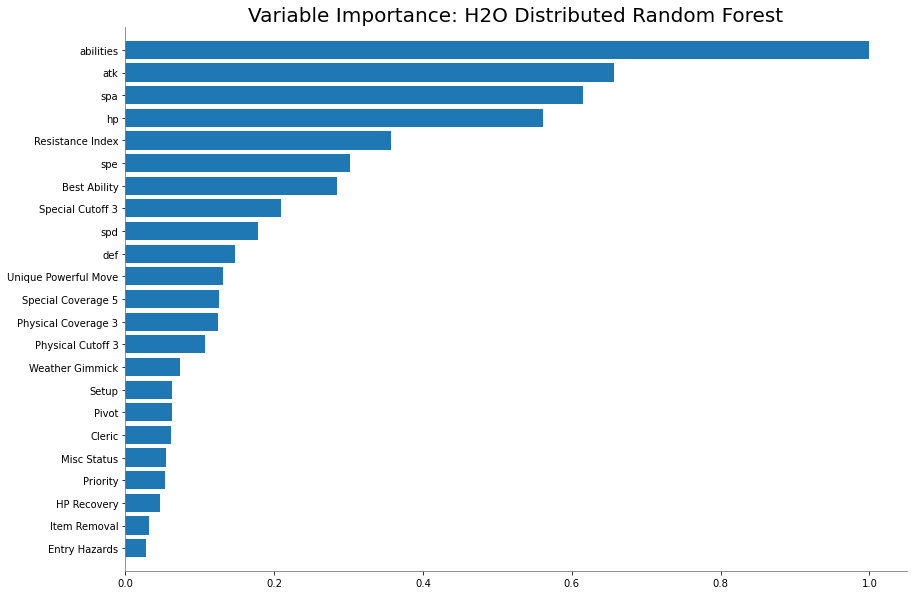

In [87]:
second_stage.varimp_plot(23)

As usual with our clustering models, the feature importances are pleasantly balanced, with most features being at least somewhat important.  Abilities seem especially important in this intermediate stage for some reason.

Now we need to set up our 3rd and final stage, with its unique versions of the data:

#### 3nd stage (of 3) of three-stage 7 class random forest with clustering

In [88]:
X_third = X_second.loc[y_df['formatsPU'] == 'Yes']
X_third

,hp,atk,def,spa,spd,spe,Resistance Index,Entry Hazards,Cleric,Pivot,...,Priority,Weather Gimmick,Physical Cutoff 3,Physical Coverage 3,Special Cutoff 3,Special Coverage 5,Misc Status,Unique Powerful Move,Best Ability,HP Recovery
name,,,,,,,,,,,,,,,,,,,,,
Venusaur,80,82,83,100,100,80,2,0,0,0,...,0,5,6,4,6,4,4,0,63.636364,3
Blastoise,79,83,100,85,105,78,2,0,0,3,...,2,2,12,10,11,7,4,0,75.000000,0
Nidoqueen,90,92,87,75,85,76,6,2,0,0,...,2,2,18,12,15,10,2,0,50.000000,0
Nidoking,81,102,77,85,75,85,6,2,0,0,...,2,2,19,13,15,10,2,0,50.000000,0
Clefable,95,70,73,95,90,60,5,2,3,1,...,0,2,8,10,17,8,3,0,100.000000,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Regidrago,200,100,50,100,50,80,1,0,0,0,...,0,0,7,4,2,2,1,0,1.000000,0
Glastrier,100,145,130,65,110,30,-3,0,0,0,...,0,1,12,7,3,2,2,0,75.000000,0
Spectrier,100,65,60,145,80,130,8,0,0,0,...,0,0,4,4,4,3,3,0,1.000000,0


In [89]:
y_third_7 = y_df['formats'].loc[y_df['formatsPU'] == 'Yes']
y_third_7

name
Venusaur            OU
Blastoise           NU
Nidoqueen           UU
Nidoking            OU
Clefable          Uber
                  ... 
Regidrago           RU
Glastrier           NU
Spectrier         Uber
Calyrex-Ice       Uber
Calyrex-Shadow    Uber
Name: formats, Length: 244, dtype: object

In [90]:
rf_grid_dict = {}

#sets up the nested dictionary structure
for n in n_clusters:
    rf_grid_dict[n] = {}

for n in n_clusters:
    for c_type in cluster_types:
        #merging the clusters into the data
        X_final = pd.merge(X_third, cluster_dfs[n][c_type], on='name')
        
        #I don't like the h2o version of train_test_split
        #it doesn't offer stratify, so we're just using sklearn
        X_train, X_test, y_train, y_test = train_test_split(X_final, y_third_7,
                                                    test_size=0.25,
                                                    random_state=273,
                                                    stratify=y_third_7.values)
        
        #merging features with target variable since that's the format h2o uses
        data = X_train.merge(y_train, on='name')
        
        #making pokemon name a column so that we can track it later
        #becasue h2o frames don't keep row indexes, they are only numerical
        #it will be dropped during training, after the train test split
        data['name'] = data.index
        cols = data.columns.tolist()
        cols = cols[-1:] + cols[:-1]
        data = data[cols]
        
        data_h2 = h2o.H2OFrame(data)
        
        #turn the one-hot encoded unique powerful moves, and our target variable...
        #...into categoricals
        data_h2['Unique Powerful Move'] = data_h2['Unique Powerful Move'].asfactor()
        data_h2[c_type] = data_h2[c_type].asfactor()
        data_h2['formats'] = data_h2['formats'].asfactor()
        
        rf_grid = H2OGridSearch(model=H2ORandomForestEstimator, hyper_params=param_grid)
        rf_grid.train(x=data_h2.drop(['name', 'formats']).columns, y='formats', training_frame=data_h2, seed=273, nfolds=2, fold_assignment="Stratified", balance_classes=True, max_depth=10, min_rows=5, nbins=20)
    
        rf_grid_dict[n][c_type] = rf_grid.get_grid()

Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
drf Grid Build progress: |███████████████████████████████████████████████████████| (done) 100%
Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
drf Grid Build progress: |███████████████████████████████████████████████████████| (done) 100%
Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
drf Grid Build progress: |███████████████████████████████████████████████████████| (done) 100%
Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
drf Grid Build progress: |███████████████████████████████████████████████████████| (done) 100%
Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
drf Grid Build progress: |███████████████████████████████████████████████████████| (done) 100%
Parse progress: |█████████████████████████████████

In [91]:
best = (0, 0, 0, 0)

for n in n_clusters:
    for c_type in cluster_types:
        count = 0
        ##remake the data_h2 again for each n and c_type
        X_final = pd.merge(X_third, cluster_dfs[n][c_type], on='name')
        X_train, X_test, y_train, y_test = train_test_split(X_final, y_third_7,
                                                    test_size=0.25,
                                                    random_state=273,
                                                    stratify=y_third_7.values)
        data = X_train.merge(y_train, on='name')
        data['name'] = data.index
        cols = data.columns.tolist()
        cols = cols[-1:] + cols[:-1]
        data = data[cols]
        data_h2 = h2o.H2OFrame(data)
        data_h2['Unique Powerful Move'] = data_h2['Unique Powerful Move'].asfactor()
        data_h2[c_type] = data_h2[c_type].asfactor()
        data_h2['formats'] = data_h2['formats'].asfactor()
        for model in rf_grid_dict[n][c_type]:
            data_h2['prediction'] = model.predict(data_h2.drop(['name', 'formats']))[0]
            data_result = data_h2.as_data_frame()
            score = f1_score(data_result['formats'], data_result['prediction'], labels=['NU', 'RU', 'UU', 'OU', 'Uber'], average='weighted')
            if score > best[0]:
                best = (score, n, c_type, count)
            count+=1
    
best

Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
drf prediction progress: |███████████████████████████████████████████████████████| (done) 100%
drf prediction progress: |███████████████████████████████████████████████████████| (done) 100%
Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
drf prediction progress: |███████████████████████████████████████████████████████| (done) 100%
drf prediction progress: |███████████████████████████████████████████████████████| (done) 100%
Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
drf prediction progress: |███████████████████████████████████████████████████████| (done) 100%
drf prediction progress: |███████████████████████████████████████████████████████| (done) 100%
Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
drf prediction progress: |████████████████████████

(0.9404811106988125, 25, 'learnsets', 0)

And learnsets won out in the 3rd stage. I actually like that, because we have stats being the most important in stage one, abilities in stage two, and learnsets in stage three, and that was entirely organic.

In [92]:
third_stage = rf_grid_dict[25]['learnsets'][0]

##remake the data_h2 again for 15 learnsets clusters
X_final = pd.merge(X_third, cluster_dfs[25]['learnsets'], on='name')
X_train, X_test, y_train, y_test = train_test_split(X_final, y_third_7,
                                                    test_size=0.25,
                                                    random_state=273,
                                                    stratify=y_third_7.values)
data = X_train.merge(y_train, on='name')
data['name'] = data.index
cols = data.columns.tolist()
cols = cols[-1:] + cols[:-1]
data = data[cols]
data_h2 = h2o.H2OFrame(data)
data_h2['Unique Powerful Move'] = data_h2['Unique Powerful Move'].asfactor()
data_h2['learnsets'] = data_h2['learnsets'].asfactor()
data_h2['formats'] = data_h2['formats'].asfactor()

data_h2['prediction'] = third_stage.predict(data_h2.drop(['name', 'formats']))[0]
data_result = data_h2.as_data_frame()
f1_score(data_result['formats'], data_result['prediction'], labels=['NU', 'RU', 'UU', 'OU', 'Uber'], average='weighted')

Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
drf prediction progress: |███████████████████████████████████████████████████████| (done) 100%


0.9404811106988125

In [93]:
rf_grid_dict[25]['learnsets']

     ntrees  \
0     128.0   
1      64.0   

                                                           model_ids   logloss  
0  Grid_DRF_py_365_sid_a1ca_model_python_1640465017333_24620_model_2  1.584510  
1  Grid_DRF_py_365_sid_a1ca_model_python_1640465017333_24620_model_1  1.618973  


In [94]:
third_stage.summary()


Model Summary: 


,,number_of_trees,number_of_internal_trees,model_size_in_bytes,min_depth,max_depth,mean_depth,min_leaves,max_leaves,mean_leaves
0,,128.0,640.0,153485.0,4.0,10.0,6.770312,10.0,19.0,14.44375


And we have 128 trees for the 3rd stage, so the 2nd stage was the only stage using only 64 trees

In [95]:
precision_recall_fscore_support(data_result['formats'], data_result['prediction'], labels=['NU', 'RU', 'UU', 'OU', 'Uber'])

(array([1.        , 0.97058824, 0.96774194, 0.84313725, 0.97435897]),
 array([0.90322581, 0.94285714, 0.88235294, 1.        , 0.95      ]),
 array([0.94915254, 0.95652174, 0.92307692, 0.91489362, 0.96202532]),
 array([31, 35, 34, 43, 40], dtype=int64))

Again these are very good scores, but we still have to be concerned about overfitting.

In [96]:
data_result.loc[data_result['formats'] != data_result['prediction']]

,name,hp,atk,def,spa,spd,spe,Resistance Index,Entry Hazards,Cleric,...,Physical Coverage 3,Special Cutoff 3,Special Coverage 5,Misc Status,Unique Powerful Move,Best Ability,HP Recovery,learnsets,formats,prediction
36,Celebi,100,100,100,100,100,100,-2,2,2,...,3,10,8,3,0,100.000000,3,11,RU,OU
63,Articuno-Galar,90,85,85,125,100,95,3,0,0,...,2,8,4,1,0,83.333333,3,4,NU,OU
73,Machamp,90,130,80,65,85,55,0,0,0,...,9,3,3,2,0,100.000000,0,6,NU,OU
77,Decidueye,78,107,75,100,100,70,7,0,0,...,4,8,4,4,1,20.000000,3,23,RU,OU
115,Necrozma,97,107,101,127,89,79,-1,2,0,...,8,12,8,3,0,83.333333,3,2,UU,Uber
116,Diancie,50,100,150,100,150,50,4,2,1,...,4,8,5,2,1,64.285714,1,2,UU,RU
117,Heliolisk,62,55,52,109,94,109,5,0,0,...,7,9,6,4,0,100.000000,0,19,NU,UU
120,Noivern,85,70,80,97,80,123,5,0,0,...,7,12,8,4,0,55.555556,3,23,UU,OU
145,Urshifu,100,130,100,63,60,97,4,0,0,...,11,4,2,2,1,100.000000,2,6,Uber,OU
153,Reuniclus,110,65,75,125,85,30,-1,0,0,...,8,11,7,3,0,100.000000,4,11,UU,OU


It's tending to overpredict the strength of certain pokemon, especially legendaries like Celebi and Articuno-Galar, but overall it's very few wrong and some of the positions of these pokemon are more flexible and debateable anyways.

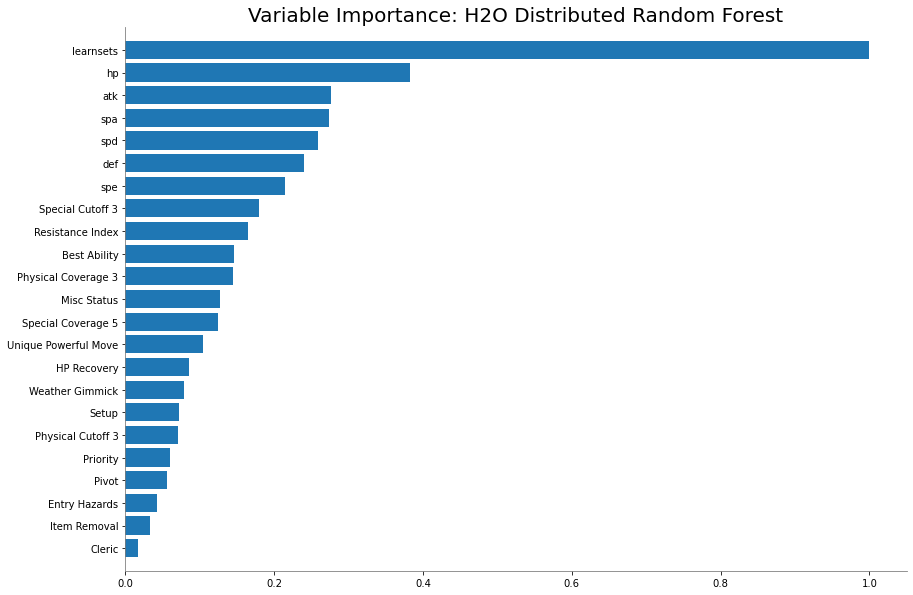

In [97]:
third_stage.varimp_plot(23)

The clusters are always the most important when used, but in this model they are even more important than usual. Still, the results aren't very unbalanced, just very niche skills like cleric are super unimportant

#### final training data result of three-stage random forest

In [128]:
#data prep for 3 stage, quite complicated
X_final = pd.merge(X, cluster_dfs[5]['stats'], on='name')
X_final = pd.merge(X_final, cluster_dfs[25]['abilities'], on='name')
X_final = pd.merge(X_final, cluster_dfs[25]['learnsets'], on='name')
X_train, X_test, y_train, y_test = train_test_split(X_final, y_df['formats2'],
                                                    test_size=0.25,
                                                    random_state=273,
                                                    stratify=y_df['formats2'].values)
data = X_train.merge(y_train, on='name')
data['name'] = data.index
cols = data.columns.tolist()
cols = cols[-1:] + cols[:-1]
data = data[cols]
data_h2 = h2o.H2OFrame(data)
data_h2['Unique Powerful Move'] = data_h2['Unique Powerful Move'].asfactor()
data_h2['stats'] = data_h2['stats'].asfactor()
data_h2['abilities'] = data_h2['abilities'].asfactor()
data_h2['learnsets'] = data_h2['learnsets'].asfactor()
data_h2['formats2'] = data_h2['formats2'].asfactor()

pred_1 = data_h2['name']
pred_1['prediction'] = first_stage.predict(data_h2.drop(['name', 'abilities', 'learnsets', 'formats2']))[0]

pred_1_mask = pred_1['prediction'] == 'Yes'

pred_2 = data_h2['name'][pred_1_mask]
pred_2['prediction'] = second_stage.predict(data_h2.drop(['name', 'stats', 'learnsets', 'formats2'])[pred_1_mask, :])[0]

#before we make pred_2 mask, we need pred_2 to have same length as data_h2
#so we need to make y_pred first to normalize its length via NaN's
y_pred = pred_1.as_data_frame().merge(pred_2.as_data_frame(), on='name', how='left')
pred_2_mask = y_pred['prediction_y'] == 'Yes'
pred_2_mask = h2o.H2OFrame(pred_2_mask.to_frame())

pred_final = data_h2['name'][pred_2_mask]
pred_final['prediction'] = third_stage.predict(data_h2.drop(['name', 'stats', 'abilities', 'formats2'])[pred_2_mask, :])[0]

y_pred = y_pred.merge(pred_final.as_data_frame(), on='name', how='left')
y_pred.loc[y_pred['prediction_x'] == 'No', 'prediction'] = 'ZU'
y_pred.loc[y_pred['prediction_y'] == 'No', 'prediction'] = 'PU'
y_pred = y_pred['prediction']
y_pred

#this step is important to get formats in the same order as the training data
y_validation = y_train.to_frame().merge(y_df['formats'], on='name', how='left')['formats']
y_validation

Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
drf prediction progress: |███████████████████████████████████████████████████████| (done) 100%
drf prediction progress: |███████████████████████████████████████████████████████| (done) 100%
Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
drf prediction progress: |███████████████████████████████████████████████████████| (done) 100%


name
Absol              PU
Ninetales-Alola    OU
Palossand          PU
Ponyta-Galar       ZU
Carvanha           ZU
                   ..
Dragonair          ZU
Qwilfish           PU
Cryogonal          PU
Wailord            ZU
Blaziken           OU
Name: formats, Length: 553, dtype: object

In [129]:
f1_score(y_validation, y_pred, labels=['ZU', 'PU', 'NU', 'RU', 'UU', 'OU', 'Uber'], average='weighted')

0.854440505173783

In [130]:
precision_recall_fscore_support(y_validation, y_pred, labels=['ZU', 'PU', 'NU', 'RU', 'UU', 'OU', 'Uber'])

(array([0.95256917, 0.88888889, 0.78571429, 0.73529412, 0.65714286,
        0.64150943, 0.73809524]),
 array([0.96015936, 0.75590551, 0.73333333, 0.73529412, 0.67647059,
        0.82926829, 0.86111111]),
 array([0.95634921, 0.81702128, 0.75862069, 0.73529412, 0.66666667,
        0.72340426, 0.79487179]),
 array([251, 127,  30,  34,  34,  41,  36], dtype=int64))

The results on the training data are slightly worse than the result of the two-stage model. Perhaps 3 stage leads to more overfitting, but one way we can find out is by trying it on the test data:

#### final test data result of three-stage random forest!!!

In [131]:
#data prep for 3 stage, quite complicated
X_final = pd.merge(X, cluster_dfs[5]['stats'], on='name')
X_final = pd.merge(X_final, cluster_dfs[25]['abilities'], on='name')
X_final = pd.merge(X_final, cluster_dfs[25]['learnsets'], on='name')
X_train, X_test, y_train, y_test = train_test_split(X_final, y_df['formats2'],
                                                    test_size=0.25,
                                                    random_state=273,
                                                    stratify=y_df['formats2'].values)
data_test = X_test.merge(y_test, on='name')
data_test['name'] = data_test.index
cols = data_test.columns.tolist()
cols = cols[-1:] + cols[:-1]
data_test = data_test[cols]
data_h2_test = h2o.H2OFrame(data_test)
data_h2_test['Unique Powerful Move'] = data_h2_test['Unique Powerful Move'].asfactor()
data_h2_test['stats'] = data_h2_test['stats'].asfactor()
data_h2_test['abilities'] = data_h2_test['abilities'].asfactor()
data_h2_test['learnsets'] = data_h2_test['learnsets'].asfactor()
data_h2_test['formats2'] = data_h2_test['formats2'].asfactor()

pred_1 = data_h2_test['name']
pred_1['prediction'] = first_stage.predict(data_h2_test.drop(['name', 'abilities', 'learnsets', 'formats2']))[0]

pred_1_mask = pred_1['prediction'] == 'Yes'

pred_2 = data_h2_test['name'][pred_1_mask]
pred_2['prediction'] = second_stage.predict(data_h2_test.drop(['name', 'stats', 'learnsets', 'formats2'])[pred_1_mask, :])[0]

#before we make pred_2 mask, we need pred_2 to have same length as data_h2
#so we need to make y_pred first to normalize its length via NaN's
y_pred = pred_1.as_data_frame().merge(pred_2.as_data_frame(), on='name', how='left')
pred_2_mask = y_pred['prediction_y'] == 'Yes'
pred_2_mask = h2o.H2OFrame(pred_2_mask.to_frame())

pred_final = data_h2_test['name'][pred_2_mask]
pred_final['prediction'] = third_stage.predict(data_h2_test.drop(['name', 'stats', 'abilities', 'formats2'])[pred_2_mask, :])[0]

y_pred = y_pred.merge(pred_final.as_data_frame(), on='name', how='left')
y_pred.loc[y_pred['prediction_x'] == 'No', 'prediction'] = 'ZU'
y_pred.loc[y_pred['prediction_y'] == 'No', 'prediction'] = 'PU'
y_pred = y_pred['prediction']
y_pred

#this step is important to get formats in the same order as the training data
y_validation = y_test.to_frame().merge(y_df['formats'], on='name', how='left')['formats']
y_validation

Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
drf prediction progress: |███████████████████████████████████████████████████████| (done) 100%
drf prediction progress: |███████████████████████████████████████████████████████| (done) 100%
Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
drf prediction progress: |███████████████████████████████████████████████████████| (done) 100%


name
Necrozma              UU
Indeedee              RU
Polteageist           UU
Flareon               PU
Pikachu               PU
                    ... 
Dugtrio               PU
Tentacool             ZU
Tyrunt                ZU
Snom                  ZU
Darmanitan-Galar    Uber
Name: formats, Length: 185, dtype: object

In [132]:
f1_score(y_validation, y_pred, labels=['ZU', 'PU', 'NU', 'RU', 'UU', 'OU', 'Uber'], average='weighted')

0.762195234195234

In [133]:
precision_recall_fscore_support(y_validation, y_pred, labels=['ZU', 'PU', 'NU', 'RU', 'UU', 'OU', 'Uber'])

(array([0.92105263, 0.64516129, 0.45454545, 0.61538462, 0.9       ,
        0.52      , 0.78947368]),
 array([0.83333333, 0.625     , 0.45454545, 0.66666667, 0.75      ,
        0.76470588, 0.88235294]),
 array([0.875     , 0.63492063, 0.45454545, 0.64      , 0.81818182,
        0.61904762, 0.83333333]),
 array([84, 32, 11, 12, 12, 17, 17], dtype=int64))

It performs worse on both training and test data than our best two-stage model, so apparently a 3rd stage doesn't really help!

<a id="save"></a>
### Saving the Best Model

First we need to remake the model again, one last time

In [134]:
##remake the data_h2 again for 5 stats clusters
X_final = pd.merge(X, cluster_dfs[5]['stats'], on='name')
X_train, X_test, y_train, y_test = train_test_split(X_final, y_df['formats2'],
                                                    test_size=0.25,
                                                    random_state=273,
                                                    stratify=y_df['formats2'].values)
data = X_train.merge(y_train, on='name')
data['name'] = data.index
cols = data.columns.tolist()
cols = cols[-1:] + cols[:-1]
data = data[cols]
data_h2 = h2o.H2OFrame(data)
data_h2['Unique Powerful Move'] = data_h2['Unique Powerful Move'].asfactor()
data_h2['stats'] = data_h2['stats'].asfactor()
data_h2['formats2'] = data_h2['formats2'].asfactor()

first_stage = H2ORandomForestEstimator(seed=273, nfolds=2, fold_assignment="Stratified", balance_classes=True, ntrees=128, max_depth=10, min_rows=5, nbins=20)
first_stage.train(x=data_h2.drop(['name', 'formats2']).columns, y='formats2', training_frame=data_h2)

data_h2['prediction'] = first_stage.predict(data_h2.drop(['name', 'formats2']))[0]
data_result = data_h2.as_data_frame()
f1_score(data_result['formats2'], data_result['prediction'], labels=['No', 'Yes'], average='weighted')

Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
drf prediction progress: |███████████████████████████████████████████████████████| (done) 100%


0.9602298479984674

In [135]:
##remake the data_h2 again for 15 learnsets clusters
X_final = pd.merge(X_second, cluster_dfs[15]['learnsets'], on='name')
X_train, X_test, y_train, y_test = train_test_split(X_final, y_second_7,
                                                    test_size=0.25,
                                                    random_state=273,
                                                    stratify=y_second_7.values)
data = X_train.merge(y_train, on='name')
data['name'] = data.index
cols = data.columns.tolist()
cols = cols[-1:] + cols[:-1]
data = data[cols]
data_h2 = h2o.H2OFrame(data)
data_h2['Unique Powerful Move'] = data_h2['Unique Powerful Move'].asfactor()
data_h2['learnsets'] = data_h2['learnsets'].asfactor()
data_h2['formats'] = data_h2['formats'].asfactor()

second_stage = H2ORandomForestEstimator(seed=273, nfolds=2, fold_assignment="Stratified", balance_classes=True, ntrees=128, max_depth=10, min_rows=5, nbins=20)
second_stage.train(x=data_h2.drop(['name', 'formats']).columns, y='formats', training_frame=data_h2)

data_h2['prediction'] = second_stage.predict(data_h2.drop(['name', 'formats']))[0]
data_result = data_h2.as_data_frame()
f1_score(data_result['formats'], data_result['prediction'], labels=['PU', 'NU', 'RU', 'UU', 'OU', 'Uber'], average='weighted')

Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
drf prediction progress: |███████████████████████████████████████████████████████| (done) 100%


0.9635991571674135

In [140]:
h2o.save_model(model=first_stage, path='./best_model/first_stage')
h2o.save_model(model=second_stage, path='./best_model/second_stage')

'D:\\Springboard\\Springboard\\SecondCapstone\\best_model\\second_stage\\DRF_model_python_1640465017333_25271'